# Fase 4: Modeling

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import glob
import pickle
import random

import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

from tqdm.auto import tqdm

In [ ]:
# ==========================
# CONFIGURACIÓN
# ==========================

BASE_FOLDER = "/content/drive/MyDrive/root/UNAM/semestre9/mineria-masiva"
LABELS_CSV = "/content/drive/MyDrive/root/UNAM/semestre9/mineria-masiva/labels.csv"

OUT_FOLDER = os.path.join(BASE_FOLDER, "out")
DATA_FOLDER = os.path.join(OUT_FOLDER, "data")
os.makedirs(OUT_FOLDER, exist_ok=True)
os.makedirs(DATA_FOLDER, exist_ok=True)

MANIFEST_PATH = os.path.join(DATA_FOLDER, "manifest.csv")

EXPECTED_X = 96
EXPECTED_Y = 96
TARGET_Z   = 50

MIN_CHANNELS_TOTAL = 65   # incluye canal 0 (b0)
DIFF_CHANNELS      = 64   # canales de difusión usados (1..64)

BATCH_SIZE    = 8
NUM_EPOCHS    = 150
LEARNING_RATE = 1e-4
NUM_WORKERS   = 2

BLOCK_FRACTION = 0.2  # cada bloque ~20% de los sujetos válidos

# Mapeo binario: 0 = control sano, 1 = paciente (cualquier diagnóstico)
DIAG_TO_INT = {
    "CONTROL": 0,
    "SCHZ": 1,
    "BIPOLAR": 1,
    "ADHD": 1,
}


# Modelos Clasicos

In [ ]:
BASE_PATH = "/content/drive/MyDrive/root/UNAM/semestre9/mineria-masiva"
OUTPUT_CSV  = os.path.join(BASE_PATH,'dwi_block_features_for_svm.csv')

In [ ]:
df_feats = pd.read_csv(OUTPUT_CSV)
df_feats.head()

subject_id  FA_BLOCK_000  FA_BLOCK_001  FA_BLOCK_002  FA_BLOCK_003  \
0  sub-10159           0.0           0.0           0.0           0.0   
1  sub-10171           0.0           0.0           0.0           0.0   
2  sub-10189           0.0           0.0           0.0           0.0   
3  sub-10193           0.0           0.0           0.0           0.0   
4  sub-10206           0.0           0.0           0.0           0.0   

   FA_BLOCK_004  FA_BLOCK_005  FA_BLOCK_006  FA_BLOCK_007  FA_BLOCK_008  ...  \
0           0.0           0.0           0.0           0.0           0.0  ...   
1           0.0           0.0           0.0           0.0           0.0  ...   
2           0.0           0.0           0.0           0.0           0.0  ...   
3           0.0           0.0           0.0           0.0           0.0  ...   
4           0.0           0.0           0.0           0.0           0.0  ...   

   FA_BLOCK_504  FA_BLOCK_505  FA_BLOCK_506  FA_BLOCK_507  FA_BLOCK_508  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   
2           0.0           0.0           0.0           0.0           0.0   
3           0.0           0.0           0.0           0.0           0.0   
4           0.0           0.0           0.0           0.0           0.0   

   FA_BLOCK_509  FA_BLOCK_510  FA_BLOCK_511  diagnosis  label_int  
0           0.0           0.0           0.0    CONTROL          0  
1           0.0           0.0           0.0    CONTROL          0  
2           0.0           0.0           0.0    CONTROL          0  
3           0.0           0.0           0.0    CONTROL          0  
4           0.0           0.0           0.0    CONTROL          0  

[5 rows x 515 columns]

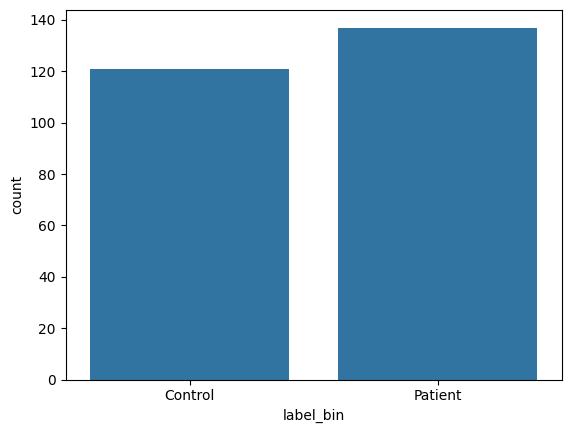

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
df_feats['label_bin'] = df_feats['diagnosis'].apply(lambda x: 0 if x == 'CONTROL' else 1)
# Visualizar la distribución de clases
sns.countplot(x='label_bin', data=df_feats)
#rename labels
plt.xticks([0, 1], ['Control', 'Patient'])
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [ ]:
#recuperar los columnas FA_BLOCK
X = df_feats[df_feats.columns[df_feats.columns.str.startswith('FA_BLOCK')]]
y = df_feats['label_bin']



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(class_weight="balanced"))
])

param_grid = {
    "svm__kernel": ["rbf", "linear"],
    "svm__C": [0.1, 1, 10, 100],
    "svm__gamma": ["scale", "auto", 0.01, 0.1],
}

grid_search = GridSearchCV(
    pipe,
    param_grid,
    cv=5,
    scoring="balanced_accuracy",
    n_jobs=-1  # Use all available cores
)

print("Starting Grid Search...")
grid_search.fit(X_train, y_train)

print(f"Best hyperparameters: {grid_search.best_params_}")
print(f"Best balanced accuracy: {grid_search.best_score_:.4f}")

# Save the best model
best_model = grid_search.best_estimator_

Starting Grid Search...
Best hyperparameters: {'svm__C': 0.1, 'svm__gamma': 'scale', 'svm__kernel': 'linear'}
Best balanced accuracy: 0.5934


In [ ]:
PATH_SVM = os.path.join(
    BASE_PATH,
    "out",
    "svm_model.pkl"
)
with open(PATH_SVM, "wb") as f:
    pickle.dump(best_model, f)

### Volumenes

In [ ]:
# ==========================
# UTILIDADES DE CARGA
# ==========================

def find_dwi_files(base_folder):
    """
    Busca archivos *dwi*.nii* en subcarpetas de base_folder.
    Asume estructura base_folder/sub-XXXX/.../algo_dwi.nii.gz
    Devuelve dict {subject_id: path_dwi}
    """
    pattern = os.path.join(base_folder, "**", "*dwi*.nii*")
    dwi_paths = glob.glob(pattern, recursive=True)

    subjects = {}
    for dwi_path in dwi_paths:
        rel = os.path.relpath(dwi_path, base_folder)
        parts = rel.split(os.sep)
        subject_id = parts[0]
        subjects[subject_id] = dwi_path

    return subjects


def load_labels(labels_csv):
    """
    Lee labels.csv con columnas: subject_id, diagnosis
    y devuelve dict {subject_id: diagnosis_str}
    """
    df = pd.read_csv(labels_csv)
    df["subject_id"] = df["subject_id"].astype(str).str.strip()
    df["diagnosis"] = df["diagnosis"].astype(str).str.strip().str.upper()
    return dict(zip(df["subject_id"], df["diagnosis"]))


def quick_check_shape(path):
    """
    Carga solo cabecera para revisar shape (X,Y,Z,C) sin leer todo el volumen.
    Devuelve shape o None si hay problema.
    """
    try:
        img = nib.load(path)
        return img.shape
    except Exception as e:
        print(f"  ! Error cargando cabecera de {path}: {e}")
        return None


def load_and_preprocess_dwi(path):
    """
    Carga un DWI (NIfTI) y aplica reglas de shape/canales:

      - Espera data 4D (X,Y,Z,C).
      - X,Y deben ser EXPECTED_X, EXPECTED_Y.
      - Si Z < TARGET_Z -> descarta (return None).
      - Si Z > TARGET_Z -> recorta slices iniciales en Z.
      - Si C < MIN_CHANNELS_TOTAL -> descarta.
      - Elimina canal 0 (b0) y usa canales 1..(1+DIFF_CHANNELS-1).
      - Normaliza z-score sobre voxels > 0.
      - Reordena a (C, D, H, W).

    Devuelve:
      tensor float32 de shape (C, D, H, W)
      o None si el volumen se descarta.
    """
    img = nib.load(path)
    data = img.get_fdata()  # (X,Y,Z,C)

    if data.ndim != 4:
        print(f"  ! {path}: no es 4D, se descarta.")
        return None

    x, y, z, c = data.shape

    if x != EXPECTED_X or y != EXPECTED_Y:
        print(f"  ! {path}: XY={x}x{y} distinto de {EXPECTED_X}x{EXPECTED_Y}, se descarta.")
        return None

    if z < TARGET_Z:
        print(f"  ! {path}: Z={z} < {TARGET_Z}, se descarta.")
        return None
    elif z > TARGET_Z:
        extra = z - TARGET_Z
        data = data[:, :, extra:, :]
        z = TARGET_Z

    if c < MIN_CHANNELS_TOTAL:
        print(f"  ! {path}: C={c} < {MIN_CHANNELS_TOTAL}, se descarta.")
        return None

    # quitamos canal 0 (b0) y tomamos DIFF_CHANNELS canales de difusión
    start_ch = 1
    end_ch = start_ch + DIFF_CHANNELS  # 1..64
    if end_ch > c:
        print(f"  ! {path}: tras quitar canal 0 no hay {DIFF_CHANNELS} canales de difusión, se descarta.")
        return None

    data = data[:, :, :, start_ch:end_ch]  # (X,Y,Z,DIFF_CHANNELS)

    # Normalización z-score sobre voxels > 0
    mask = data > 0
    if np.any(mask):
        mean = data[mask].mean()
        std = data[mask].std()
        if std > 0:
            data = (data - mean) / std
        else:
            data = data - mean
    else:
        print(f"  ! {path}: todos los voxels son 0 tras recorte, se descarta.")
        return None

    # Reordenar a (C, D, H, W) → (chan, z, y, x)
    data = np.transpose(data, (3, 2, 1, 0)).astype(np.float32)

    return torch.from_numpy(data)

# ==========================
# CANDIDATOS + EXPORT POR BLOQUES
# ==========================

def discover_candidates(base_folder, labels_csv):
    """
    Descubre sujetos candidatos (por shape básico) SIN cargar el volumen completo.
    Devuelve lista de (subject_id, path, label_int).
    """
    labels_dict = load_labels(labels_csv)
    subject_to_path = find_dwi_files(base_folder)

    candidates = []

    for subj_id, path in subject_to_path.items():
        if subj_id not in labels_dict:
            continue

        diag_str = labels_dict[subj_id].upper()
        if diag_str not in DIAG_TO_INT:
            continue

        label_int = DIAG_TO_INT[diag_str]

        candidates.append((subj_id, path, label_int))

    print(f"Total sujetos candidatos (por shape/canales mínimos): {len(candidates)}")
    return candidates


def export_blocks_and_manifest(candidates, block_fraction=0.2):
    """
    Recorre la lista de candidatos, carga+preprocesa cada volumen y
    los va guardando en bloques (~20% del total) para no explotar la RAM
    al hacer un pickle gigante.

    - Exporta:
        data/block_000.pkl, block_001.pkl, ...
        Cada bloque tiene: dict(volumes, labels, subject_ids)
    - Crea manifest.csv con columnas:
        global_index, subject_id, label, block_id, index_in_block
    """
    if len(candidates) == 0:
        raise RuntimeError("No hay candidatos para exportar bloques.")

    block_size = max(1, int(len(candidates) * block_fraction))
    print(f"Usando block_size={block_size} (~{block_fraction*100:.0f}% de {len(candidates)})")

    block_id = 0
    current_vols = []
    current_labels = []
    current_subjs = []

    manifest_rows = []
    global_index = 0

    for subj_id, path, label_int in tqdm(candidates, desc="Procesando y exportando bloques", unit="subject"):
        vol = load_and_preprocess_dwi(path)
        if vol is None:
            continue

        # índice dentro del bloque actual
        index_in_block = len(current_vols)

        current_vols.append(vol)
        current_labels.append(label_int)
        current_subjs.append(subj_id)

        # fila de bitácora
        manifest_rows.append({
            "global_index": global_index,
            "subject_id": subj_id,
            "label": label_int,
            "block_id": block_id,
            "index_in_block": index_in_block
        })
        global_index += 1

        # si el bloque llegó al tamaño, lo guardamos y limpiamos buffers
        if len(current_vols) >= block_size:
            block_path = os.path.join(DATA_FOLDER, f"block_{block_id:03d}.pkl")
            with open(block_path, "wb") as f:
                pickle.dump({
                    "volumes": current_vols,
                    "labels": current_labels,
                    "subject_ids": current_subjs,
                }, f)
            print(f"  -> Guardado bloque {block_id} con {len(current_vols)} sujetos en {block_path}")

            block_id += 1
            current_vols = []
            current_labels = []
            current_subjs = []

    # guardar bloque final (si quedó algo)
    if len(current_vols) > 0:
        block_path = os.path.join(DATA_FOLDER, f"block_{block_id:03d}.pkl")
        with open(block_path, "wb") as f:
            pickle.dump({
                "volumes": current_vols,
                "labels": current_labels,
                "subject_ids": current_subjs,
            }, f)
        print(f"  -> Guardado bloque final {block_id} con {len(current_vols)} sujetos en {block_path}")

    # guardar manifest
    df_manifest = pd.DataFrame(manifest_rows)
    df_manifest.to_csv(MANIFEST_PATH, index=False)
    print(f"Bitácora guardada en {MANIFEST_PATH}")
    print(f"Total sujetos válidos exportados: {len(manifest_rows)}")


def list_block_files():
    """
    Devuelve lista ordenada de paths a bloques block_XXX.pkl
    """
    pattern = os.path.join(DATA_FOLDER, "block_*.pkl")
    files = sorted(glob.glob(pattern))
    return files

def load_all_blocks_to_ram(n=5):
    """
    Carga TODOS los bloques block_XXX.pkl a RAM y devuelve:
      volumes: lista de tensores (C,D,H,W)
      labels : lista de ints
    (Los subject_ids se guardan en los bloques y en manifest.csv,
     pero para entrenamiento sólo necesitamos volumes+labels.)
    """
    block_files = list_block_files()
    if not block_files:
        raise RuntimeError("No hay bloques block_*.pkl en data/. Primero ejecuta export_blocks_and_manifest.")
    block_files = block_files[:n]
    all_volumes = []
    all_labels = []

    print("Cargando todos los bloques a RAM...")
    for block_path in tqdm(block_files, desc="Cargando bloques", unit="block"):
        with open(block_path, "rb") as f:
            data = pickle.load(f)
        vols_b = data["volumes"]
        labels_b = data["labels"]
        all_volumes.extend(vols_b)
        all_labels.extend(labels_b)

    print(f"Total sujetos cargados desde bloques: {len(all_volumes)}")
    return all_volumes, all_labels

## CNN 3

In [ ]:
volumes, labels = load_all_blocks_to_ram(n=5)

Cargando todos los bloques a RAM...


Cargando bloques:   0%|          | 0/5 [00:00<?, ?block/s]

Total sujetos cargados desde bloques: 258


In [ ]:
print(len(volumes))

258


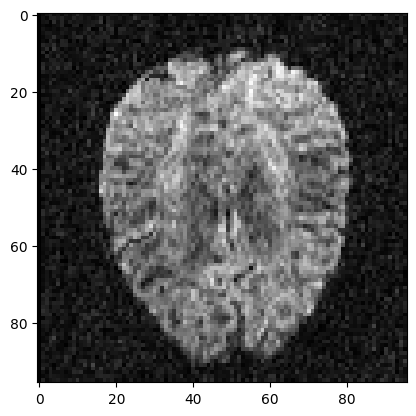

In [ ]:
#tensor to numpy
raw1 = volumes[0].numpy()
middle_slide_image = raw1[0,20,:,:]
plt.imshow(middle_slide_image, cmap='gray')
plt.show()

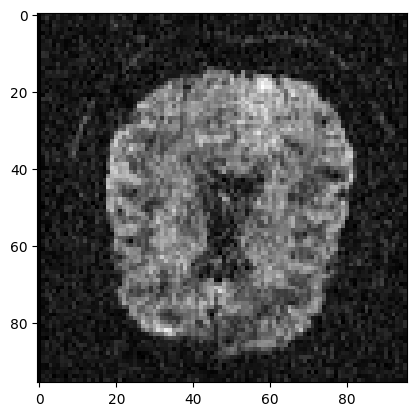

In [ ]:
#tensor to numpy
raw1 = volumes[10].numpy()
middle_slide_image = raw1[0,20,:,:]
plt.imshow(middle_slide_image, cmap='gray')
plt.show()

In [ ]:
# ==========================
# DATASET EN MEMORIA
# ==========================
class InMemoryDWIDataset(Dataset):
    """
    Dataset simple que asume que los volúmenes ya están cargados en RAM.
    volumes: lista de tensores (C,D,H,W)
    labels:  lista de ints
    """

    def __init__(self, volumes, labels):
        assert len(volumes) == len(labels)
        self.volumes = volumes
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.volumes[idx], self.labels[idx]

In [ ]:
class ImprovedCNN3D(nn.Module):
    """
    CNN 3D mejorada con técnicas de regularización para evitar overfitting:
    - Dropout en múltiples etapas
    - Batch Normalization
    - Conexiones residuales (skip connections)
    - Data augmentation implícita (usar durante training)
    - Regularización L2 (weight decay en optimizer)
    """
    def __init__(self, in_channels=64, num_classes=2, dropout_rate=0.2):
        super().__init__()

        # ========================================
        # BLOQUE 1: Extracción inicial de características
        # ========================================
        self.block1 = nn.Sequential(
            nn.Conv3d(in_channels, 32, kernel_size=3, stride=1, padding=1),  # Padding=1 para mantener tamaño
            nn.BatchNorm3d(32),
            nn.ReLU(inplace=True),
            nn.Dropout3d(p=0.1),  # Dropout ligero inicial
        )

        # ========================================
        # BLOQUE 2: Profundización con MaxPool
        # ========================================
        self.block2 = nn.Sequential(
            nn.Conv3d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=2, stride=2),  # Reduce dimensiones a la mitad
            nn.Dropout3d(p=0.1),  # Dropout moderado
        )

        # ========================================
        # BLOQUE 3: Características de alto nivel
        # ========================================
        self.block3 = nn.Sequential(
            nn.Conv3d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=2, stride=2),  # Reduce dimensiones nuevamente
            nn.Dropout3d(p=0.1),  # Dropout más agresivo
        )

        # ========================================
        # BLOQUE 4: Refinamiento final
        # ========================================
        self.block4 = nn.Sequential(
            nn.Conv3d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(256),
            nn.ReLU(inplace=True),
            nn.Dropout3d(p=0.1),
        )

        # ========================================
        # POOLING GLOBAL
        # ========================================
        self.global_pool = nn.AdaptiveAvgPool3d(1)

        # ========================================
        # CLASIFICADOR con Dropout
        # ========================================
        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),  # Dropout fuerte antes de clasificación
            nn.Linear(128, num_classes)
        )

        # Inicialización de pesos (He initialization para ReLU)
        self._initialize_weights()

    def _initialize_weights(self):
        """Inicialización de pesos para mejor convergencia"""
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # x shape: (Batch, Channels, Depth, Height, Width)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)

        x = self.global_pool(x)        # -> (Batch, 256, 1, 1, 1)
        x = torch.flatten(x, 1)        # -> (Batch, 256)
        x = self.classifier(x)         # -> (Batch, num_classes)

        return x

In [ ]:
import torch
import torch.nn as nn

class DirectCNN3D_Stride1(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        # Stride=1: Desplaza cubo a cubo (1 voxel a la vez)
        # Padding=0: Sin agregar bordes artificiales
        self.features = nn.Sequential(
            # Capa 1: stride=1, padding=0
            # Input: (B, C, D, H, W) -> Output: (B, 32, D-2, H-2, W-2)
            nn.Conv3d(in_channels, 32, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm3d(32),
            nn.ReLU(inplace=True),

            # Capa 2: stride=1, padding=0
            # Reduce aún más las dimensiones espaciales
            nn.Conv3d(32, 64, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),

            # Capa 3: stride=1, padding=0
            nn.Conv3d(64, 128, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm3d(128),
            nn.ReLU(inplace=True),
        )

        # Global Average Pooling: colapsa dimensiones espaciales
        self.pool = nn.AdaptiveAvgPool3d(1)

        # Clasificador
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x):
        # x shape: (Batch, Channels, Depth, Height, Width)
        x = self.features(x)

        x = self.pool(x)        # -> (Batch, 128, 1, 1, 1)
        x = torch.flatten(x, 1) # -> (Batch, 128)

        x = self.classifier(x)  # -> (Batch, num_classes)
        return x


def instancia_directCNN3d_stride1():
    return DirectCNN3D_Stride1(in_channels=64, num_classes=2)


In [ ]:
# ==========================
# LOOP DE ENTRENAMIENTO
# ==========================
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import os
import copy


def train(
    volumes,
    labels,
    out_dir,
    instance_model,
    model_name,
    gap_threshold=0.2,
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    dataset = InMemoryDWIDataset(volumes, labels)
    total = len(dataset)

    # ---- PARTICIÓN 80% TRAIN, 10% VAL, 10% TEST ----
    n_train = int(0.8 * total)
    n_val   = int(0.1 * total)
    n_test  = total - n_train - n_val   # suma exacta

    train_ds, val_ds, test_ds = random_split(
        dataset,
        [n_train, n_val, n_test],
        generator=torch.Generator().manual_seed(42)
    )

    print(f"Train: {len(train_ds)}  |  Val: {len(val_ds)}  |  Test: {len(test_ds)}")
    print(f"Batch {BATCH_SIZE}")


    # ---- DATALOADERS ----
    train_loader = DataLoader(
        train_ds, batch_size=BATCH_SIZE, shuffle=True,
        num_workers=NUM_WORKERS, pin_memory=True
    )
    val_loader = DataLoader(
        val_ds, batch_size=BATCH_SIZE, shuffle=False,
        num_workers=NUM_WORKERS, pin_memory=True
    )
    test_loader = DataLoader(
        test_ds, batch_size=BATCH_SIZE, shuffle=False,
        num_workers=NUM_WORKERS, pin_memory=True
    )

    model = instance_model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=LEARNING_RATE,
    )

    history = {
        "epoch": [],
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": [],
        "gap_loss": [],
        "weighted_acc": [],  # Nueva métrica
    }

    # ---- VARIABLES PARA MEJOR MODELO ----
    best_weighted_acc = 0.0
    best_model_state = None
    best_epoch = 0

    # ========== LOOP DE ENTRENAMIENTO ==========
    for epoch in range(1, NUM_EPOCHS + 1):
        # ------- TRAIN -------
        model.train()
        running_loss = 0.0
        correct = 0
        total_samples = 0

        for vols, labels_batch in tqdm(
            train_loader,
            desc=f"Epoch {epoch}/{NUM_EPOCHS} [train]",
            leave=False
        ):
            vols = vols.to(device)
            labels_batch = labels_batch.to(device)

            optimizer.zero_grad()
            outputs = model(vols)
            loss = criterion(outputs, labels_batch)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * vols.size(0)
            _, predicted = outputs.max(1)
            total_samples += labels_batch.size(0)
            correct += predicted.eq(labels_batch).sum().item()

        train_loss = running_loss / total_samples
        train_acc = correct / total_samples

        # ------- VALID -------
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        for vols, labels_batch in tqdm(
            val_loader,
            desc=f"Epoch {epoch}/{NUM_EPOCHS} [val]",
            leave=False
        ):
            vols = vols.to(device)
            labels_batch = labels_batch.to(device)
            with torch.no_grad():
                outputs = model(vols)
                loss = criterion(outputs, labels_batch)

            val_loss += loss.item() * vols.size(0)
            _, predicted = outputs.max(1)
            val_total += labels_batch.size(0)
            val_correct += predicted.eq(labels_batch).sum().item()

        val_loss /= val_total
        val_acc = val_correct / val_total

        gap_loss = val_loss - train_loss

        # ---- CALCULAR ACCURACY PONDERADA: 40% train, 60% val ----
        weighted_acc = 0.4 * train_acc + 0.6 * val_acc

        # ---- GUARDAR MEJOR MODELO ----
        if weighted_acc > best_weighted_acc:
            best_weighted_acc = weighted_acc
            best_epoch = epoch
            best_model_state = copy.deepcopy(model.state_dict())
            print(f"  ⭐ Nuevo mejor modelo! Weighted Acc: {weighted_acc:.4f} (época {epoch})")

        # ---- GUARDAR EN HISTORIA ----
        history["epoch"].append(epoch)
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        history["gap_loss"].append(gap_loss)
        history["weighted_acc"].append(weighted_acc)

        print(
            f"Epoch [{epoch}/{NUM_EPOCHS}] "
            f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
            f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f} | "
            f"Gap: {gap_loss:.4f} | "
            f"Weighted Acc: {weighted_acc:.4f}"
        )

    print(f"\n{'='*70}")
    print(f"🏆 MEJOR MODELO: Época {best_epoch} con Weighted Acc = {best_weighted_acc:.4f}")
    print(f"{'='*70}\n")

    # ---- GUARDAR HISTORIA EN CSV ----
    df_hist = pd.DataFrame(history)
    csv_path = os.path.join(out_dir, f"{model_name}.csv")
    df_hist.to_csv(csv_path, index=False)
    print(f"Log de entrenamiento guardado en {csv_path}")

    # ---- PLOTS MEJORADOS ----
    epochs = history["epoch"]

    fig = plt.figure(figsize=(15, 5))

    # Subplot 1: Loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, history["train_loss"], label="Train loss", marker='o', markersize=3)
    plt.plot(epochs, history["val_loss"], label="Val loss", marker='s', markersize=3)
    plt.axvline(x=best_epoch, color='red', linestyle='--', alpha=0.5, label=f'Best (epoch {best_epoch})')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Evolución de la pérdida")
    plt.legend()
    plt.grid(alpha=0.3)

    # Subplot 2: Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(epochs, history["train_acc"], label="Train acc", marker='o', markersize=3)
    plt.plot(epochs, history["val_acc"], label="Val acc", marker='s', markersize=3)
    plt.axvline(x=best_epoch, color='red', linestyle='--', alpha=0.5, label=f'Best (epoch {best_epoch})')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Evolución de la accuracy")
    plt.legend()
    plt.grid(alpha=0.3)

    # Subplot 3: Weighted Accuracy
    plt.subplot(1, 3, 3)
    plt.plot(epochs, history["weighted_acc"], label="Weighted Acc (0.4T + 0.6V)",
             marker='D', markersize=3, color='purple', linewidth=2)
    plt.axvline(x=best_epoch, color='red', linestyle='--', alpha=0.5, label=f'Best (epoch {best_epoch})')
    plt.axhline(y=best_weighted_acc, color='green', linestyle=':', alpha=0.5, label=f'Max: {best_weighted_acc:.4f}')
    plt.xlabel("Epoch")
    plt.ylabel("Weighted Accuracy")
    plt.title("Accuracy Ponderada (Métrica de selección)")
    plt.legend()
    plt.grid(alpha=0.3)

    plt.tight_layout()

    # Guardar figura
    fig_path = os.path.join(out_dir, f"{model_name}_training.png")
    plt.savefig(fig_path, dpi=150, bbox_inches='tight')
    print(f"Gráfica guardada en {fig_path}")
    plt.show()

    # ---- EVALUACIÓN FINAL EN TEST CON MEJOR MODELO ----
    print(f"\n{'='*70}")
    print(f"EVALUANDO MEJOR MODELO EN TEST")
    print(f"{'='*70}")

    # Cargar mejor modelo
    model.load_state_dict(best_model_state)
    model.eval()

    test_loss = 0.0
    test_correct = 0
    test_total = 0

    for vols, labels_batch in tqdm(test_loader, desc="Evaluando en test", leave=False):
        vols = vols.to(device)
        labels_batch = labels_batch.to(device)
        with torch.no_grad():
            outputs = model(vols)
            loss = criterion(outputs, labels_batch)

        test_loss += loss.item() * vols.size(0)
        _, predicted = outputs.max(1)
        test_total += labels_batch.size(0)
        test_correct += predicted.eq(labels_batch).sum().item()

    test_loss /= test_total
    test_acc = test_correct / test_total

    print("\n========== RESULTADOS EN TEST (MEJOR MODELO) ==========")
    print(f"Mejor modelo de época: {best_epoch}")
    print(f"Weighted Acc (train-val): {best_weighted_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    print("=======================================================\n")

    # ---- GUARDAR MODELOS ----
    # 1. Guardar MEJOR modelo con prefijo "best_"
    best_model_path = os.path.join(out_dir, f"best_{model_name}.pth")
    torch.save(best_model_state, best_model_path)
    print(f"✓ Mejor modelo guardado en: {best_model_path}")

    # 2. Guardar modelo final (última época)
    final_model_path = os.path.join(out_dir, f"{model_name}.pth")
    torch.save(model.state_dict(), final_model_path)
    print(f"✓ Modelo final guardado en: {final_model_path}")

    # 3. Guardar información del mejor modelo
    best_info = {
        "best_epoch": best_epoch,
        "best_weighted_acc": best_weighted_acc,
        "best_train_acc": history["train_acc"][best_epoch - 1],
        "best_val_acc": history["val_acc"][best_epoch - 1],
        "test_acc": test_acc,
        "test_loss": test_loss,
    }

    best_info_path = os.path.join(out_dir, f"best_{model_name}_info.txt")
    with open(best_info_path, 'w') as f:
        f.write(f"{'='*50}\n")
        f.write(f"INFORMACIÓN DEL MEJOR MODELO\n")
        f.write(f"{'='*50}\n")
        f.write(f"Modelo: {model_name}\n")
        f.write(f"Época seleccionada: {best_epoch}/{NUM_EPOCHS}\n")
        f.write(f"\nMétricas en época {best_epoch}:\n")
        f.write(f"  - Train Accuracy: {best_info['best_train_acc']:.4f}\n")
        f.write(f"  - Val Accuracy: {best_info['best_val_acc']:.4f}\n")
        f.write(f"  - Weighted Acc (0.4T + 0.6V): {best_weighted_acc:.4f}\n")
        f.write(f"\nRendimiento en Test:\n")
        f.write(f"  - Test Loss: {test_loss:.4f}\n")
        f.write(f"  - Test Accuracy: {test_acc:.4f}\n")
        f.write(f"{'='*50}\n")

    print(f"✓ Información guardada en: {best_info_path}")

    return best_info


# Modelo directo

In [ ]:
modeloImprove = ImprovedCNN3D()
modeloImprove.load_state_dict(
    torch.load("/content/drive/MyDrive/root/UNAM/semestre9/mineria-masiva/out/v2_cnn.pth")
)
print(modeloImprove)

ImprovedCNN3D(
  (block1): Sequential(
    (0): Conv3d(64, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout3d(p=0.1, inplace=False)
  )
  (block2): Sequential(
    (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout3d(p=0.1, inplace=False)
  )
  (block3): Sequential(
    (0): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout3d(p=0.1, inplace=False)
  )
  (bl

Train: 206  |  Val: 25  |  Test: 27
Batch 8


  ⭐ Nuevo mejor modelo! Weighted Acc: 0.4912 (época 1)
Epoch [1/150] Train Loss: 0.6717 Acc: 0.5680 | Val Loss: 0.6919 Acc: 0.4400 | Gap: 0.0202 | Weighted Acc: 0.4912


  ⭐ Nuevo mejor modelo! Weighted Acc: 0.5171 (época 2)
Epoch [2/150] Train Loss: 0.6743 Acc: 0.5728 | Val Loss: 0.6647 Acc: 0.4800 | Gap: -0.0095 | Weighted Acc: 0.5171


  ⭐ Nuevo mejor modelo! Weighted Acc: 0.5717 (época 3)
Epoch [3/150] Train Loss: 0.6809 Acc: 0.5291 | Val Loss: 0.6439 Acc: 0.6000 | Gap: -0.0370 | Weighted Acc: 0.5717


Epoch [4/150] Train Loss: 0.6768 Acc: 0.5680 | Val Loss: 0.6849 Acc: 0.5200 | Gap: 0.0081 | Weighted Acc: 0.5392


Epoch [5/150] Train Loss: 0.6688 Acc: 0.6019 | Val Loss: 0.6595 Acc: 0.5200 | Gap: -0.0093 | Weighted Acc: 0.5528


Epoch [6/150] Train Loss: 0.6428 Acc: 0.6359 | Val Loss: 0.6695 Acc: 0.5200 | Gap: 0.0267 | Weighted Acc: 0.5664


Epoch [7/150] Train Loss: 0.6561 Acc: 0.6019 | Val Loss: 0.6677 Acc: 0.4800 | Gap: 0.0116 | Weighted Acc: 0.5288


  ⭐ Nuevo mejor modelo! Weighted Acc: 0.6209 (época 8)
Epoch [8/150] Train Loss: 0.6791 Acc: 0.5922 | Val Loss: 0.6326 Acc: 0.6400 | Gap: -0.0465 | Weighted Acc: 0.6209


Epoch [9/150] Train Loss: 0.6613 Acc: 0.5971 | Val Loss: 0.6619 Acc: 0.6000 | Gap: 0.0006 | Weighted Acc: 0.5988


Epoch [10/150] Train Loss: 0.6561 Acc: 0.6117 | Val Loss: 0.6726 Acc: 0.5200 | Gap: 0.0165 | Weighted Acc: 0.5567


  ⭐ Nuevo mejor modelo! Weighted Acc: 0.6488 (época 11)
Epoch [11/150] Train Loss: 0.6502 Acc: 0.6019 | Val Loss: 0.6203 Acc: 0.6800 | Gap: -0.0298 | Weighted Acc: 0.6488


Epoch [12/150] Train Loss: 0.6744 Acc: 0.5583 | Val Loss: 0.6276 Acc: 0.6400 | Gap: -0.0468 | Weighted Acc: 0.6073


Epoch [13/150] Train Loss: 0.6680 Acc: 0.5631 | Val Loss: 0.7066 Acc: 0.4800 | Gap: 0.0385 | Weighted Acc: 0.5132


Epoch [14/150] Train Loss: 0.6589 Acc: 0.6214 | Val Loss: 0.6357 Acc: 0.6000 | Gap: -0.0232 | Weighted Acc: 0.6085


Epoch [15/150] Train Loss: 0.6694 Acc: 0.5534 | Val Loss: 0.6720 Acc: 0.5200 | Gap: 0.0025 | Weighted Acc: 0.5334


Epoch [16/150] Train Loss: 0.6690 Acc: 0.5680 | Val Loss: 0.6463 Acc: 0.5200 | Gap: -0.0228 | Weighted Acc: 0.5392


Epoch [17/150] Train Loss: 0.6449 Acc: 0.5971 | Val Loss: 0.6970 Acc: 0.4800 | Gap: 0.0521 | Weighted Acc: 0.5268


Epoch [18/150] Train Loss: 0.6773 Acc: 0.5680 | Val Loss: 0.6222 Acc: 0.6000 | Gap: -0.0551 | Weighted Acc: 0.5872


Epoch [19/150] Train Loss: 0.6728 Acc: 0.5922 | Val Loss: 0.6708 Acc: 0.5600 | Gap: -0.0020 | Weighted Acc: 0.5729


Epoch [20/150] Train Loss: 0.6444 Acc: 0.6068 | Val Loss: 0.6327 Acc: 0.5200 | Gap: -0.0117 | Weighted Acc: 0.5547


Epoch [21/150] Train Loss: 0.6546 Acc: 0.6019 | Val Loss: 0.6798 Acc: 0.5200 | Gap: 0.0252 | Weighted Acc: 0.5528


Epoch [22/150] Train Loss: 0.6490 Acc: 0.6262 | Val Loss: 0.6390 Acc: 0.5600 | Gap: -0.0100 | Weighted Acc: 0.5865


Epoch [23/150] Train Loss: 0.6517 Acc: 0.6311 | Val Loss: 0.6796 Acc: 0.5600 | Gap: 0.0279 | Weighted Acc: 0.5884


Epoch [24/150] Train Loss: 0.6673 Acc: 0.5874 | Val Loss: 0.6296 Acc: 0.6000 | Gap: -0.0377 | Weighted Acc: 0.5950


Epoch [25/150] Train Loss: 0.6368 Acc: 0.6408 | Val Loss: 0.6853 Acc: 0.5200 | Gap: 0.0485 | Weighted Acc: 0.5683


Epoch [26/150] Train Loss: 0.6681 Acc: 0.5825 | Val Loss: 0.6451 Acc: 0.5200 | Gap: -0.0230 | Weighted Acc: 0.5450


Epoch [27/150] Train Loss: 0.6789 Acc: 0.5874 | Val Loss: 0.6754 Acc: 0.5200 | Gap: -0.0036 | Weighted Acc: 0.5470


Epoch [28/150] Train Loss: 0.6783 Acc: 0.5971 | Val Loss: 0.6386 Acc: 0.5600 | Gap: -0.0396 | Weighted Acc: 0.5748


Epoch [29/150] Train Loss: 0.6602 Acc: 0.5971 | Val Loss: 0.6458 Acc: 0.5200 | Gap: -0.0143 | Weighted Acc: 0.5508


Epoch [30/150] Train Loss: 0.6392 Acc: 0.6359 | Val Loss: 0.6900 Acc: 0.5200 | Gap: 0.0508 | Weighted Acc: 0.5664


Epoch [31/150] Train Loss: 0.6402 Acc: 0.6214 | Val Loss: 0.6207 Acc: 0.6400 | Gap: -0.0194 | Weighted Acc: 0.6325


Epoch [32/150] Train Loss: 0.6520 Acc: 0.5777 | Val Loss: 0.6832 Acc: 0.5600 | Gap: 0.0313 | Weighted Acc: 0.5671


Epoch [33/150] Train Loss: 0.6353 Acc: 0.6262 | Val Loss: 0.6447 Acc: 0.5200 | Gap: 0.0094 | Weighted Acc: 0.5625


Epoch [34/150] Train Loss: 0.6305 Acc: 0.6553 | Val Loss: 0.6780 Acc: 0.5600 | Gap: 0.0475 | Weighted Acc: 0.5981


Epoch [35/150] Train Loss: 0.6471 Acc: 0.6408 | Val Loss: 0.6345 Acc: 0.5200 | Gap: -0.0125 | Weighted Acc: 0.5683


Epoch [36/150] Train Loss: 0.6380 Acc: 0.6117 | Val Loss: 0.6300 Acc: 0.6000 | Gap: -0.0080 | Weighted Acc: 0.6047


Epoch [37/150] Train Loss: 0.6388 Acc: 0.6214 | Val Loss: 0.6385 Acc: 0.5200 | Gap: -0.0003 | Weighted Acc: 0.5605


Epoch [38/150] Train Loss: 0.6692 Acc: 0.5777 | Val Loss: 0.6183 Acc: 0.6000 | Gap: -0.0509 | Weighted Acc: 0.5911


Epoch [39/150] Train Loss: 0.6665 Acc: 0.5825 | Val Loss: 0.6920 Acc: 0.5200 | Gap: 0.0255 | Weighted Acc: 0.5450


Epoch [40/150] Train Loss: 0.6452 Acc: 0.6019 | Val Loss: 0.6466 Acc: 0.5200 | Gap: 0.0013 | Weighted Acc: 0.5528


Epoch [41/150] Train Loss: 0.6669 Acc: 0.6068 | Val Loss: 0.6316 Acc: 0.4800 | Gap: -0.0353 | Weighted Acc: 0.5307


Epoch [42/150] Train Loss: 0.6507 Acc: 0.6262 | Val Loss: 0.6375 Acc: 0.5600 | Gap: -0.0131 | Weighted Acc: 0.5865


Epoch [43/150] Train Loss: 0.6387 Acc: 0.6408 | Val Loss: 0.6330 Acc: 0.6400 | Gap: -0.0057 | Weighted Acc: 0.6403


Epoch [44/150] Train Loss: 0.6094 Acc: 0.6505 | Val Loss: 0.6322 Acc: 0.5200 | Gap: 0.0228 | Weighted Acc: 0.5722


Epoch [45/150] Train Loss: 0.6383 Acc: 0.6311 | Val Loss: 0.6898 Acc: 0.5600 | Gap: 0.0515 | Weighted Acc: 0.5884


Epoch [46/150] Train Loss: 0.6661 Acc: 0.6262 | Val Loss: 0.6343 Acc: 0.5600 | Gap: -0.0319 | Weighted Acc: 0.5865


Epoch [47/150] Train Loss: 0.6735 Acc: 0.5825 | Val Loss: 0.6279 Acc: 0.5600 | Gap: -0.0456 | Weighted Acc: 0.5690


Epoch [48/150] Train Loss: 0.6472 Acc: 0.6068 | Val Loss: 0.6530 Acc: 0.6400 | Gap: 0.0058 | Weighted Acc: 0.6267


Epoch [49/150] Train Loss: 0.6573 Acc: 0.6262 | Val Loss: 0.6500 Acc: 0.6000 | Gap: -0.0073 | Weighted Acc: 0.6105


Epoch [50/150] Train Loss: 0.6356 Acc: 0.6165 | Val Loss: 0.6568 Acc: 0.6000 | Gap: 0.0212 | Weighted Acc: 0.6066


Epoch [51/150] Train Loss: 0.6338 Acc: 0.6553 | Val Loss: 0.6556 Acc: 0.6000 | Gap: 0.0218 | Weighted Acc: 0.6221


Epoch [52/150] Train Loss: 0.6310 Acc: 0.6505 | Val Loss: 0.6812 Acc: 0.5200 | Gap: 0.0502 | Weighted Acc: 0.5722


Epoch [53/150] Train Loss: 0.6433 Acc: 0.5922 | Val Loss: 0.6453 Acc: 0.4800 | Gap: 0.0020 | Weighted Acc: 0.5249


Epoch [54/150] Train Loss: 0.6429 Acc: 0.6214 | Val Loss: 0.6422 Acc: 0.5600 | Gap: -0.0008 | Weighted Acc: 0.5845


Epoch [55/150] Train Loss: 0.6302 Acc: 0.6505 | Val Loss: 0.6946 Acc: 0.5200 | Gap: 0.0644 | Weighted Acc: 0.5722


Epoch [56/150] Train Loss: 0.6399 Acc: 0.6262 | Val Loss: 0.6515 Acc: 0.5600 | Gap: 0.0115 | Weighted Acc: 0.5865


Epoch [57/150] Train Loss: 0.6654 Acc: 0.5922 | Val Loss: 0.6964 Acc: 0.5600 | Gap: 0.0311 | Weighted Acc: 0.5729


Epoch [58/150] Train Loss: 0.6376 Acc: 0.6311 | Val Loss: 0.6292 Acc: 0.5200 | Gap: -0.0084 | Weighted Acc: 0.5644


Epoch [59/150] Train Loss: 0.6175 Acc: 0.6699 | Val Loss: 0.6587 Acc: 0.5200 | Gap: 0.0412 | Weighted Acc: 0.5800


Epoch [60/150] Train Loss: 0.6479 Acc: 0.5971 | Val Loss: 0.6798 Acc: 0.5600 | Gap: 0.0320 | Weighted Acc: 0.5748


Epoch [61/150] Train Loss: 0.6181 Acc: 0.6699 | Val Loss: 0.7010 Acc: 0.5600 | Gap: 0.0830 | Weighted Acc: 0.6040


Epoch [62/150] Train Loss: 0.6150 Acc: 0.6796 | Val Loss: 0.6336 Acc: 0.6000 | Gap: 0.0186 | Weighted Acc: 0.6318


Epoch [63/150] Train Loss: 0.6465 Acc: 0.6650 | Val Loss: 0.6286 Acc: 0.6000 | Gap: -0.0178 | Weighted Acc: 0.6260


Epoch [64/150] Train Loss: 0.6368 Acc: 0.6068 | Val Loss: 0.7676 Acc: 0.4800 | Gap: 0.1308 | Weighted Acc: 0.5307


Epoch [65/150] Train Loss: 0.6155 Acc: 0.6602 | Val Loss: 0.6480 Acc: 0.5600 | Gap: 0.0325 | Weighted Acc: 0.6001


  ⭐ Nuevo mejor modelo! Weighted Acc: 0.6527 (época 66)
Epoch [66/150] Train Loss: 0.6446 Acc: 0.6117 | Val Loss: 0.6260 Acc: 0.6800 | Gap: -0.0187 | Weighted Acc: 0.6527


Epoch [67/150] Train Loss: 0.6098 Acc: 0.6602 | Val Loss: 0.6394 Acc: 0.5200 | Gap: 0.0296 | Weighted Acc: 0.5761


Epoch [68/150] Train Loss: 0.6495 Acc: 0.5971 | Val Loss: 0.6450 Acc: 0.6000 | Gap: -0.0045 | Weighted Acc: 0.5988


Epoch [69/150] Train Loss: 0.6078 Acc: 0.6699 | Val Loss: 0.6546 Acc: 0.5600 | Gap: 0.0469 | Weighted Acc: 0.6040


Epoch [70/150] Train Loss: 0.5985 Acc: 0.6845 | Val Loss: 0.6490 Acc: 0.5200 | Gap: 0.0504 | Weighted Acc: 0.5858


Epoch [71/150] Train Loss: 0.6515 Acc: 0.6553 | Val Loss: 0.6930 Acc: 0.6000 | Gap: 0.0415 | Weighted Acc: 0.6221


Epoch [72/150] Train Loss: 0.6316 Acc: 0.6650 | Val Loss: 0.6825 Acc: 0.6000 | Gap: 0.0509 | Weighted Acc: 0.6260


Epoch [73/150] Train Loss: 0.6306 Acc: 0.6262 | Val Loss: 0.6329 Acc: 0.6000 | Gap: 0.0024 | Weighted Acc: 0.6105


Epoch [74/150] Train Loss: 0.6181 Acc: 0.6214 | Val Loss: 0.6771 Acc: 0.5600 | Gap: 0.0590 | Weighted Acc: 0.5845


Epoch [75/150] Train Loss: 0.6010 Acc: 0.6990 | Val Loss: 0.6670 Acc: 0.5600 | Gap: 0.0660 | Weighted Acc: 0.6156


Epoch [76/150] Train Loss: 0.6353 Acc: 0.6117 | Val Loss: 0.6505 Acc: 0.5600 | Gap: 0.0153 | Weighted Acc: 0.5807


Epoch [77/150] Train Loss: 0.6045 Acc: 0.6748 | Val Loss: 0.6913 Acc: 0.5200 | Gap: 0.0868 | Weighted Acc: 0.5819


Epoch [78/150] Train Loss: 0.5819 Acc: 0.6699 | Val Loss: 0.6495 Acc: 0.5600 | Gap: 0.0676 | Weighted Acc: 0.6040


Epoch [79/150] Train Loss: 0.6436 Acc: 0.5971 | Val Loss: 0.6177 Acc: 0.6400 | Gap: -0.0259 | Weighted Acc: 0.6228


Epoch [80/150] Train Loss: 0.5963 Acc: 0.6456 | Val Loss: 0.6763 Acc: 0.6400 | Gap: 0.0799 | Weighted Acc: 0.6423


Epoch [81/150] Train Loss: 0.6248 Acc: 0.6748 | Val Loss: 0.6726 Acc: 0.5600 | Gap: 0.0478 | Weighted Acc: 0.6059


Epoch [82/150] Train Loss: 0.6061 Acc: 0.6553 | Val Loss: 0.6700 Acc: 0.6000 | Gap: 0.0639 | Weighted Acc: 0.6221


Epoch [83/150] Train Loss: 0.6216 Acc: 0.6553 | Val Loss: 0.6599 Acc: 0.5200 | Gap: 0.0383 | Weighted Acc: 0.5741


Epoch [84/150] Train Loss: 0.6019 Acc: 0.6602 | Val Loss: 0.6289 Acc: 0.6400 | Gap: 0.0269 | Weighted Acc: 0.6481


Epoch [85/150] Train Loss: 0.6470 Acc: 0.6408 | Val Loss: 0.6624 Acc: 0.5200 | Gap: 0.0154 | Weighted Acc: 0.5683


Epoch [86/150] Train Loss: 0.6191 Acc: 0.7087 | Val Loss: 0.6340 Acc: 0.6000 | Gap: 0.0150 | Weighted Acc: 0.6435


Epoch [87/150] Train Loss: 0.6204 Acc: 0.6505 | Val Loss: 0.7326 Acc: 0.5200 | Gap: 0.1122 | Weighted Acc: 0.5722


Epoch [88/150] Train Loss: 0.6285 Acc: 0.6214 | Val Loss: 0.6400 Acc: 0.6000 | Gap: 0.0116 | Weighted Acc: 0.6085


Epoch [89/150] Train Loss: 0.6382 Acc: 0.6214 | Val Loss: 0.6767 Acc: 0.6000 | Gap: 0.0386 | Weighted Acc: 0.6085


Epoch [90/150] Train Loss: 0.6058 Acc: 0.6650 | Val Loss: 0.6293 Acc: 0.6400 | Gap: 0.0235 | Weighted Acc: 0.6500


Epoch [91/150] Train Loss: 0.6054 Acc: 0.6845 | Val Loss: 0.6950 Acc: 0.5600 | Gap: 0.0896 | Weighted Acc: 0.6098


Epoch [92/150] Train Loss: 0.6340 Acc: 0.6214 | Val Loss: 0.6452 Acc: 0.6000 | Gap: 0.0112 | Weighted Acc: 0.6085


Epoch [93/150] Train Loss: 0.6248 Acc: 0.6602 | Val Loss: 0.6724 Acc: 0.6000 | Gap: 0.0477 | Weighted Acc: 0.6241


Epoch [94/150] Train Loss: 0.6005 Acc: 0.6505 | Val Loss: 0.6239 Acc: 0.6400 | Gap: 0.0234 | Weighted Acc: 0.6442


Epoch [95/150] Train Loss: 0.6153 Acc: 0.6505 | Val Loss: 0.6572 Acc: 0.5600 | Gap: 0.0419 | Weighted Acc: 0.5962


Epoch [96/150] Train Loss: 0.6234 Acc: 0.6699 | Val Loss: 0.6366 Acc: 0.6400 | Gap: 0.0132 | Weighted Acc: 0.6520


Epoch [97/150] Train Loss: 0.6198 Acc: 0.6165 | Val Loss: 0.6927 Acc: 0.6000 | Gap: 0.0730 | Weighted Acc: 0.6066


Epoch [98/150] Train Loss: 0.6197 Acc: 0.6311 | Val Loss: 0.6889 Acc: 0.6000 | Gap: 0.0692 | Weighted Acc: 0.6124


Epoch [99/150] Train Loss: 0.6257 Acc: 0.6359 | Val Loss: 0.6105 Acc: 0.6400 | Gap: -0.0151 | Weighted Acc: 0.6384


Epoch [100/150] Train Loss: 0.6271 Acc: 0.6456 | Val Loss: 0.7426 Acc: 0.5600 | Gap: 0.1155 | Weighted Acc: 0.5943


Epoch [101/150] Train Loss: 0.6407 Acc: 0.6214 | Val Loss: 0.6404 Acc: 0.6000 | Gap: -0.0003 | Weighted Acc: 0.6085


Epoch [102/150] Train Loss: 0.5982 Acc: 0.6650 | Val Loss: 0.6547 Acc: 0.5600 | Gap: 0.0566 | Weighted Acc: 0.6020


Epoch [103/150] Train Loss: 0.6178 Acc: 0.6602 | Val Loss: 0.6402 Acc: 0.6000 | Gap: 0.0225 | Weighted Acc: 0.6241


Epoch [104/150] Train Loss: 0.6152 Acc: 0.6553 | Val Loss: 0.6311 Acc: 0.6000 | Gap: 0.0160 | Weighted Acc: 0.6221


  ⭐ Nuevo mejor modelo! Weighted Acc: 0.6740 (época 105)
Epoch [105/150] Train Loss: 0.6132 Acc: 0.6650 | Val Loss: 0.6215 Acc: 0.6800 | Gap: 0.0083 | Weighted Acc: 0.6740


Epoch [106/150] Train Loss: 0.6251 Acc: 0.6748 | Val Loss: 0.6196 Acc: 0.6400 | Gap: -0.0055 | Weighted Acc: 0.6539


Epoch [107/150] Train Loss: 0.6226 Acc: 0.6553 | Val Loss: 0.7316 Acc: 0.5600 | Gap: 0.1090 | Weighted Acc: 0.5981


Epoch [108/150] Train Loss: 0.6195 Acc: 0.6602 | Val Loss: 0.6825 Acc: 0.5600 | Gap: 0.0631 | Weighted Acc: 0.6001


Epoch [109/150] Train Loss: 0.6202 Acc: 0.6311 | Val Loss: 0.6350 Acc: 0.6000 | Gap: 0.0148 | Weighted Acc: 0.6124


Epoch [110/150] Train Loss: 0.6208 Acc: 0.6505 | Val Loss: 0.6640 Acc: 0.5600 | Gap: 0.0433 | Weighted Acc: 0.5962


Epoch [111/150] Train Loss: 0.5972 Acc: 0.6311 | Val Loss: 0.6141 Acc: 0.6800 | Gap: 0.0169 | Weighted Acc: 0.6604


Epoch [112/150] Train Loss: 0.5890 Acc: 0.6845 | Val Loss: 0.6745 Acc: 0.5600 | Gap: 0.0855 | Weighted Acc: 0.6098


Epoch [113/150] Train Loss: 0.5924 Acc: 0.6553 | Val Loss: 0.6620 Acc: 0.5600 | Gap: 0.0696 | Weighted Acc: 0.5981


Epoch [114/150] Train Loss: 0.6157 Acc: 0.6893 | Val Loss: 0.6660 Acc: 0.5600 | Gap: 0.0503 | Weighted Acc: 0.6117


Epoch [115/150] Train Loss: 0.5932 Acc: 0.7039 | Val Loss: 0.6541 Acc: 0.5600 | Gap: 0.0610 | Weighted Acc: 0.6176


Epoch [116/150] Train Loss: 0.5780 Acc: 0.7039 | Val Loss: 0.6741 Acc: 0.5600 | Gap: 0.0961 | Weighted Acc: 0.6176


Epoch [117/150] Train Loss: 0.6147 Acc: 0.6748 | Val Loss: 0.6750 Acc: 0.6000 | Gap: 0.0604 | Weighted Acc: 0.6299


Epoch [118/150] Train Loss: 0.5914 Acc: 0.6845 | Val Loss: 0.6995 Acc: 0.5600 | Gap: 0.1080 | Weighted Acc: 0.6098


Epoch [119/150] Train Loss: 0.5912 Acc: 0.6602 | Val Loss: 0.7201 Acc: 0.6400 | Gap: 0.1289 | Weighted Acc: 0.6481


Epoch [120/150] Train Loss: 0.6143 Acc: 0.6699 | Val Loss: 0.6332 Acc: 0.6000 | Gap: 0.0189 | Weighted Acc: 0.6280


Epoch [121/150] Train Loss: 0.6184 Acc: 0.6602 | Val Loss: 0.6563 Acc: 0.5600 | Gap: 0.0379 | Weighted Acc: 0.6001


Epoch [122/150] Train Loss: 0.5932 Acc: 0.6893 | Val Loss: 0.7124 Acc: 0.6400 | Gap: 0.1192 | Weighted Acc: 0.6597


Epoch [123/150] Train Loss: 0.6071 Acc: 0.6699 | Val Loss: 0.6684 Acc: 0.5600 | Gap: 0.0613 | Weighted Acc: 0.6040


Epoch [124/150] Train Loss: 0.6397 Acc: 0.6602 | Val Loss: 0.7532 Acc: 0.4800 | Gap: 0.1135 | Weighted Acc: 0.5521


Epoch [125/150] Train Loss: 0.5955 Acc: 0.6893 | Val Loss: 0.7037 Acc: 0.6000 | Gap: 0.1082 | Weighted Acc: 0.6357


Epoch [126/150] Train Loss: 0.5867 Acc: 0.6699 | Val Loss: 0.6419 Acc: 0.6400 | Gap: 0.0552 | Weighted Acc: 0.6520


Epoch [127/150] Train Loss: 0.6056 Acc: 0.7184 | Val Loss: 0.6872 Acc: 0.5200 | Gap: 0.0817 | Weighted Acc: 0.5994


Epoch [128/150] Train Loss: 0.5797 Acc: 0.6942 | Val Loss: 0.6552 Acc: 0.5600 | Gap: 0.0754 | Weighted Acc: 0.6137


Epoch [129/150] Train Loss: 0.6435 Acc: 0.6408 | Val Loss: 0.7372 Acc: 0.6400 | Gap: 0.0937 | Weighted Acc: 0.6403


Epoch [130/150] Train Loss: 0.6128 Acc: 0.6699 | Val Loss: 0.6790 Acc: 0.5600 | Gap: 0.0662 | Weighted Acc: 0.6040


Epoch [131/150] Train Loss: 0.6096 Acc: 0.6602 | Val Loss: 0.6733 Acc: 0.5600 | Gap: 0.0638 | Weighted Acc: 0.6001


Epoch [132/150] Train Loss: 0.5906 Acc: 0.7039 | Val Loss: 0.6832 Acc: 0.5600 | Gap: 0.0926 | Weighted Acc: 0.6176


Epoch [133/150] Train Loss: 0.5951 Acc: 0.6748 | Val Loss: 0.6641 Acc: 0.6000 | Gap: 0.0690 | Weighted Acc: 0.6299


Epoch [134/150] Train Loss: 0.6171 Acc: 0.6748 | Val Loss: 0.7016 Acc: 0.5600 | Gap: 0.0845 | Weighted Acc: 0.6059


Epoch [135/150] Train Loss: 0.5977 Acc: 0.6845 | Val Loss: 0.6818 Acc: 0.5600 | Gap: 0.0841 | Weighted Acc: 0.6098


Epoch [136/150] Train Loss: 0.6227 Acc: 0.6553 | Val Loss: 0.6279 Acc: 0.6400 | Gap: 0.0052 | Weighted Acc: 0.6461


Epoch [137/150] Train Loss: 0.5991 Acc: 0.6942 | Val Loss: 0.6762 Acc: 0.5600 | Gap: 0.0770 | Weighted Acc: 0.6137


Epoch [138/150] Train Loss: 0.5893 Acc: 0.7087 | Val Loss: 0.7173 Acc: 0.6000 | Gap: 0.1280 | Weighted Acc: 0.6435


Epoch [139/150] Train Loss: 0.5775 Acc: 0.7184 | Val Loss: 0.6630 Acc: 0.6000 | Gap: 0.0855 | Weighted Acc: 0.6474


Epoch [140/150] Train Loss: 0.5819 Acc: 0.6845 | Val Loss: 0.6437 Acc: 0.6400 | Gap: 0.0619 | Weighted Acc: 0.6578


Epoch [141/150] Train Loss: 0.5940 Acc: 0.6893 | Val Loss: 0.6458 Acc: 0.6000 | Gap: 0.0518 | Weighted Acc: 0.6357


Epoch [142/150] Train Loss: 0.5753 Acc: 0.7039 | Val Loss: 0.6772 Acc: 0.5600 | Gap: 0.1018 | Weighted Acc: 0.6176


Epoch [143/150] Train Loss: 0.6059 Acc: 0.6602 | Val Loss: 0.6464 Acc: 0.6800 | Gap: 0.0405 | Weighted Acc: 0.6721


Epoch [144/150] Train Loss: 0.6225 Acc: 0.6117 | Val Loss: 0.6792 Acc: 0.5600 | Gap: 0.0567 | Weighted Acc: 0.5807


Epoch [145/150] Train Loss: 0.6307 Acc: 0.6214 | Val Loss: 0.6501 Acc: 0.6000 | Gap: 0.0194 | Weighted Acc: 0.6085


Epoch [146/150] Train Loss: 0.5835 Acc: 0.6990 | Val Loss: 0.7301 Acc: 0.6400 | Gap: 0.1466 | Weighted Acc: 0.6636


Epoch [147/150] Train Loss: 0.5634 Acc: 0.7039 | Val Loss: 0.6652 Acc: 0.5600 | Gap: 0.1018 | Weighted Acc: 0.6176


Epoch [148/150] Train Loss: 0.6006 Acc: 0.6748 | Val Loss: 0.6799 Acc: 0.5600 | Gap: 0.0793 | Weighted Acc: 0.6059


  ⭐ Nuevo mejor modelo! Weighted Acc: 0.6753 (época 149)
Epoch [149/150] Train Loss: 0.5893 Acc: 0.7282 | Val Loss: 0.6404 Acc: 0.6400 | Gap: 0.0512 | Weighted Acc: 0.6753


Epoch [150/150] Train Loss: 0.6272 Acc: 0.6553 | Val Loss: 0.6901 Acc: 0.5200 | Gap: 0.0629 | Weighted Acc: 0.5741

🏆 MEJOR MODELO: Época 149 con Weighted Acc = 0.6753

Log de entrenamiento guardado en /content/drive/MyDrive/root/UNAM/semestre9/mineria-masiva/out/v2_cnn.csv
Gráfica guardada en /content/drive/MyDrive/root/UNAM/semestre9/mineria-masiva/out/v2_cnn_training.png


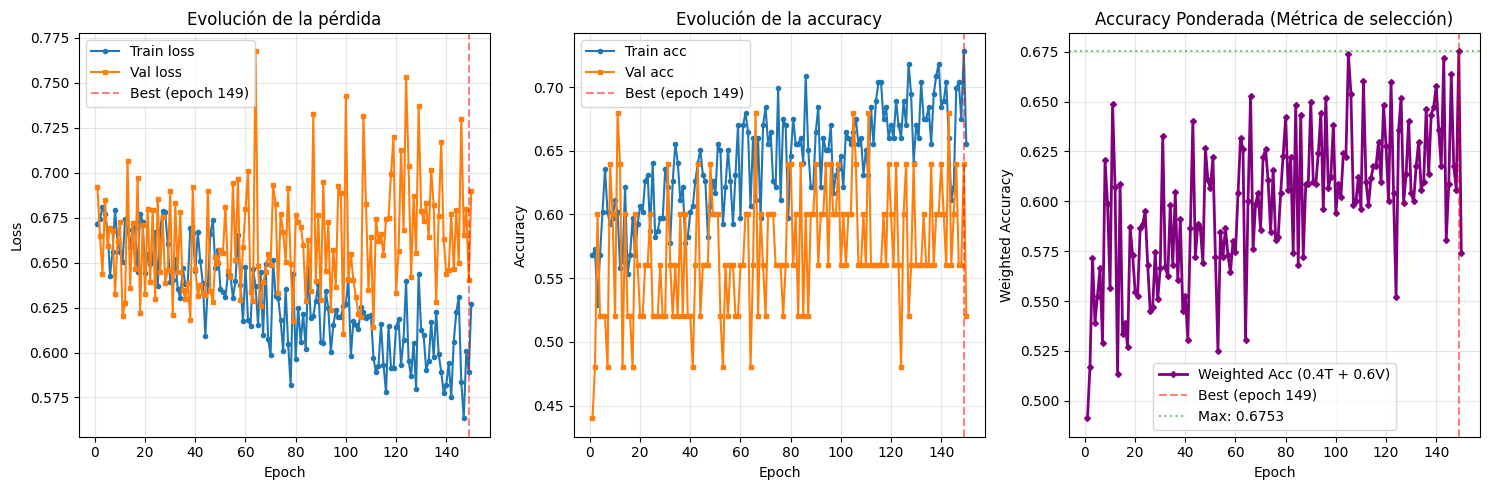


EVALUANDO MEJOR MODELO EN TEST



========== RESULTADOS EN TEST (MEJOR MODELO) ==========
Mejor modelo de época: 149
Weighted Acc (train-val): 0.6753
Test Loss: 0.7444
Test Accuracy: 0.5185

✓ Mejor modelo guardado en: /content/drive/MyDrive/root/UNAM/semestre9/mineria-masiva/out/best_v2_cnn.pth
✓ Modelo final guardado en: /content/drive/MyDrive/root/UNAM/semestre9/mineria-masiva/out/v2_cnn.pth
✓ Información guardada en: /content/drive/MyDrive/root/UNAM/semestre9/mineria-masiva/out/best_v2_cnn_info.txt


{'best_epoch': 149,
 'best_weighted_acc': 0.6752621359223301,
 'best_train_acc': 0.7281553398058253,
 'best_val_acc': 0.64,
 'test_acc': 0.5185185185185185,
 'test_loss': 0.7443973377898887}

In [ ]:
train(
    volumes,
    labels,
    OUT_FOLDER,
    modeloImprove,
    "v2_cnn"
)

In [ ]:
modeloCNN3d = DirectCNN3D_Stride1(
    in_channels=64,
    num_classes=2
)
modeloCNN3d.load_state_dict(
    torch.load("/content/drive/MyDrive/root/UNAM/semestre9/mineria-masiva/out/directCNN_2025_11_27.pth")
)
print(modeloCNN3d)

DirectCNN3D_Stride1(
  (features): Sequential(
    (0): Conv3d(64, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (7): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
  )
  (pool): AdaptiveAvgPool3d(output_size=1)
  (classifier): Linear(in_features=128, out_features=2, bias=True)
)


In [ ]:
# ========================================
# 2. EXTRAER ACTIVACIONES DE LA PRIMERA CAPA
# ========================================
def obtener_activaciones_capa(model, input_tensor, layer_name='block1'):
    """
    Extrae las activaciones de cualquier bloque del modelo mejorado

    Args:
        model: Modelo ImprovedCNN3D, ImprovedCNN3D_WithResidual o LightweightCNN3D
        input_tensor: Tensor de entrada (B, C, D, H, W) o (C, D, H, W)
        layer_name: Nombre del bloque a extraer ('block1', 'block2', 'block3', 'block4')

    Returns:
        activaciones: Tensor (B, num_filtros, D_out, H_out, W_out)
    """
    # Asegurar que tiene dimensión batch
    if input_tensor.dim() == 4:
        input_tensor = input_tensor.unsqueeze(0)  # (1, C, D, H, W)

    model.eval()

    with torch.no_grad():
        # Obtener el bloque específico
        if hasattr(model, layer_name):
            block = getattr(model, layer_name)
            activaciones = block(input_tensor)
        else:
            raise ValueError(f"El modelo no tiene el bloque '{layer_name}'")

    return activaciones

# ========================================
# 3. FUNCIÓN DE VISUALIZACIÓN POR SLICES
# ========================================
def visualizar_activaciones_por_slice(activaciones, slice_idx, max_filtros=16,
                                      cmap='viridis', figsize=(20, 12)):
    """
    Visualiza las activaciones de múltiples filtros en un slice específico

    Args:
        activaciones: Tensor (B, num_filtros, D, H, W)
        slice_idx: Índice del slice en profundidad a visualizar
        max_filtros: Número máximo de filtros a mostrar
        cmap: Colormap de matplotlib
        figsize: Tamaño de la figura
    """
    # Remover dimensión batch si existe
    if activaciones.dim() == 5:
        activaciones = activaciones[0]  # (num_filtros, D, H, W)

    num_filtros = activaciones.shape[0]
    num_filtros = min(num_filtros, max_filtros)

    # Calcular grid
    cols = 4
    rows = (num_filtros + cols - 1) // cols

    fig = plt.figure(figsize=figsize)
    fig.suptitle(f'Activaciones de Primera Capa Convolucional - Slice {slice_idx}/{activaciones.shape[1]}',
                 fontsize=16, fontweight='bold')

    for i in range(num_filtros):
        ax = fig.add_subplot(rows, cols, i + 1)

        # Extraer slice del filtro i
        activation_slice = activaciones[i, slice_idx, :, :].cpu().numpy()

        # Visualizar
        im = ax.imshow(activation_slice, cmap=cmap, aspect='auto')
        ax.set_title(f'Filtro {i}', fontsize=10)
        ax.axis('off')

        # Añadir colorbar
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

        # Estadísticas
        ax.text(0.02, 0.98, f'Min: {activation_slice.min():.2f}\nMax: {activation_slice.max():.2f}',
                transform=ax.transAxes, fontsize=8, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.show()


# ========================================
# 4. VISUALIZACIÓN COMPARATIVA: INPUT vs ACTIVACIONES
# ========================================
def comparar_input_vs_activaciones(input_tensor, activaciones,
                                   slice_idx, canal_input=0, filtro_idx=0):
    """
    Compara un canal del input con la activación de un filtro específico

    Args:
        input_tensor: Tensor de entrada (C, D, H, W) o (1, C, D, H, W)
        activaciones: Tensor de activaciones (num_filtros, D_out, H_out, W_out)
        slice_idx: Índice del slice a visualizar
        canal_input: Canal del input a mostrar
        filtro_idx: Índice del filtro a mostrar
    """
    # Preparar input
    if input_tensor.dim() == 5:
        input_tensor = input_tensor[0]

    if activaciones.dim() == 5:
        activaciones = activaciones[0]

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Input original
    input_slice = input_tensor[canal_input, slice_idx, :, :].cpu().numpy()
    im1 = axes[0].imshow(input_slice, cmap='viridis', aspect='auto')
    axes[0].set_title(f'Input - Canal {canal_input} - Slice {slice_idx}', fontsize=12, fontweight='bold')
    axes[0].axis('off')
    plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)

    # Activación
    activation_slice = activaciones[filtro_idx, slice_idx, :, :].cpu().numpy()
    im2 = axes[1].imshow(activation_slice, cmap='viridis', aspect='auto')
    axes[1].set_title(f'Activación - Filtro {filtro_idx} - Slice {slice_idx}', fontsize=12, fontweight='bold')
    axes[1].axis('off')
    plt.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)

    # Estadísticas
    axes[0].text(0.02, 0.98,
                 f'Shape: {input_slice.shape}\nMin: {input_slice.min():.2f}\nMax: {input_slice.max():.2f}\nMean: {input_slice.mean():.2f}',
                 transform=axes[0].transAxes, fontsize=9, verticalalignment='top',
                 bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    axes[1].text(0.02, 0.98,
                 f'Shape: {activation_slice.shape}\nMin: {activation_slice.min():.2f}\nMax: {activation_slice.max():.2f}\nMean: {activation_slice.mean():.2f}',
                 transform=axes[1].transAxes, fontsize=9, verticalalignment='top',
                 bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.show()


# ========================================
# 5. VISUALIZACIÓN 3D: TODOS LOS SLICES DE UN FILTRO
# ========================================
def visualizar_filtro_completo(activaciones, filtro_idx, num_slices=10, figsize=(20, 10)):
    """
    Muestra múltiples slices de un filtro específico para ver el volumen completo

    Args:
        activaciones: Tensor de activaciones (num_filtros, D, H, W)
        filtro_idx: Índice del filtro a visualizar
        num_slices: Número de slices equiespaciados a mostrar
    """
    if activaciones.dim() == 5:
        activaciones = activaciones[0]

    profundidad = activaciones.shape[1]
    slice_indices = np.linspace(0, profundidad - 1, num_slices, dtype=int)

    cols = 5
    rows = (num_slices + cols - 1) // cols

    fig = plt.figure(figsize=figsize)
    fig.suptitle(f'Filtro {filtro_idx} - Todos los Slices (Profundidad: {profundidad})',
                 fontsize=16, fontweight='bold')

    for i, slice_idx in enumerate(slice_indices):
        ax = fig.add_subplot(rows, cols, i + 1)

        activation_slice = activaciones[filtro_idx, slice_idx, :, :].cpu().numpy()

        im = ax.imshow(activation_slice, cmap='viridis', aspect='auto')
        ax.set_title(f'Slice {slice_idx}/{profundidad-1}', fontsize=10)
        ax.axis('off')
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()


# ========================================
# 6. ANÁLISIS ESTADÍSTICO DE ACTIVACIONES
# ========================================
def analizar_estadisticas_filtros(activaciones):
    """
    Muestra estadísticas de todos los filtros
    """
    if activaciones.dim() == 5:
        activaciones = activaciones[0]

    num_filtros = activaciones.shape[0]

    print(f"\n{'='*70}")
    print(f"ANÁLISIS ESTADÍSTICO DE ACTIVACIONES - PRIMERA CAPA")
    print(f"{'='*70}")
    print(f"Shape de activaciones: {activaciones.shape}")
    print(f"Número de filtros: {num_filtros}")
    print(f"\n{'Filtro':<8} {'Min':<12} {'Max':<12} {'Mean':<12} {'Std':<12} {'% Activos':<12}")
    print(f"{'-'*70}")

    for i in range(num_filtros):
        filtro = activaciones[i].cpu().numpy()
        activos = (filtro > 0).sum() / filtro.size * 100

        print(f"{i:<8} {filtro.min():<12.4f} {filtro.max():<12.4f} "
              f"{filtro.mean():<12.4f} {filtro.std():<12.4f} {activos:<12.2f}")

    print(f"{'='*70}\n")


# ========================================
# 7. HEATMAP DE ACTIVACIÓN PROMEDIO
# ========================================
def visualizar_activacion_promedio_por_filtro(activaciones, figsize=(15, 8)):
    """
    Muestra un heatmap de la activación promedio de cada filtro
    """
    if activaciones.dim() == 5:
        activaciones = activaciones[0]

    num_filtros = activaciones.shape[0]

    # Calcular estadísticas por filtro
    means = []
    maxs = []
    stds = []

    for i in range(num_filtros):
        filtro = activaciones[i].cpu().numpy()
        means.append(filtro.mean())
        maxs.append(filtro.max())
        stds.append(filtro.std())

    fig, axes = plt.subplots(1, 3, figsize=figsize)

    # Mean
    axes[0].bar(range(num_filtros), means, color='steelblue')
    axes[0].set_title('Activación Media por Filtro', fontweight='bold')
    axes[0].set_xlabel('Filtro')
    axes[0].set_ylabel('Mean')
    axes[0].grid(alpha=0.3)

    # Max
    axes[1].bar(range(num_filtros), maxs, color='coral')
    axes[1].set_title('Activación Máxima por Filtro', fontweight='bold')
    axes[1].set_xlabel('Filtro')
    axes[1].set_ylabel('Max')
    axes[1].grid(alpha=0.3)

    # Std
    axes[2].bar(range(num_filtros), stds, color='mediumseagreen')
    axes[2].set_title('Desviación Estándar por Filtro', fontweight='bold')
    axes[2].set_xlabel('Filtro')
    axes[2].set_ylabel('Std')
    axes[2].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

In [ ]:
v0 = volumes[0]
activaciones = obtener_activaciones_capa(modeloImprove, v0)

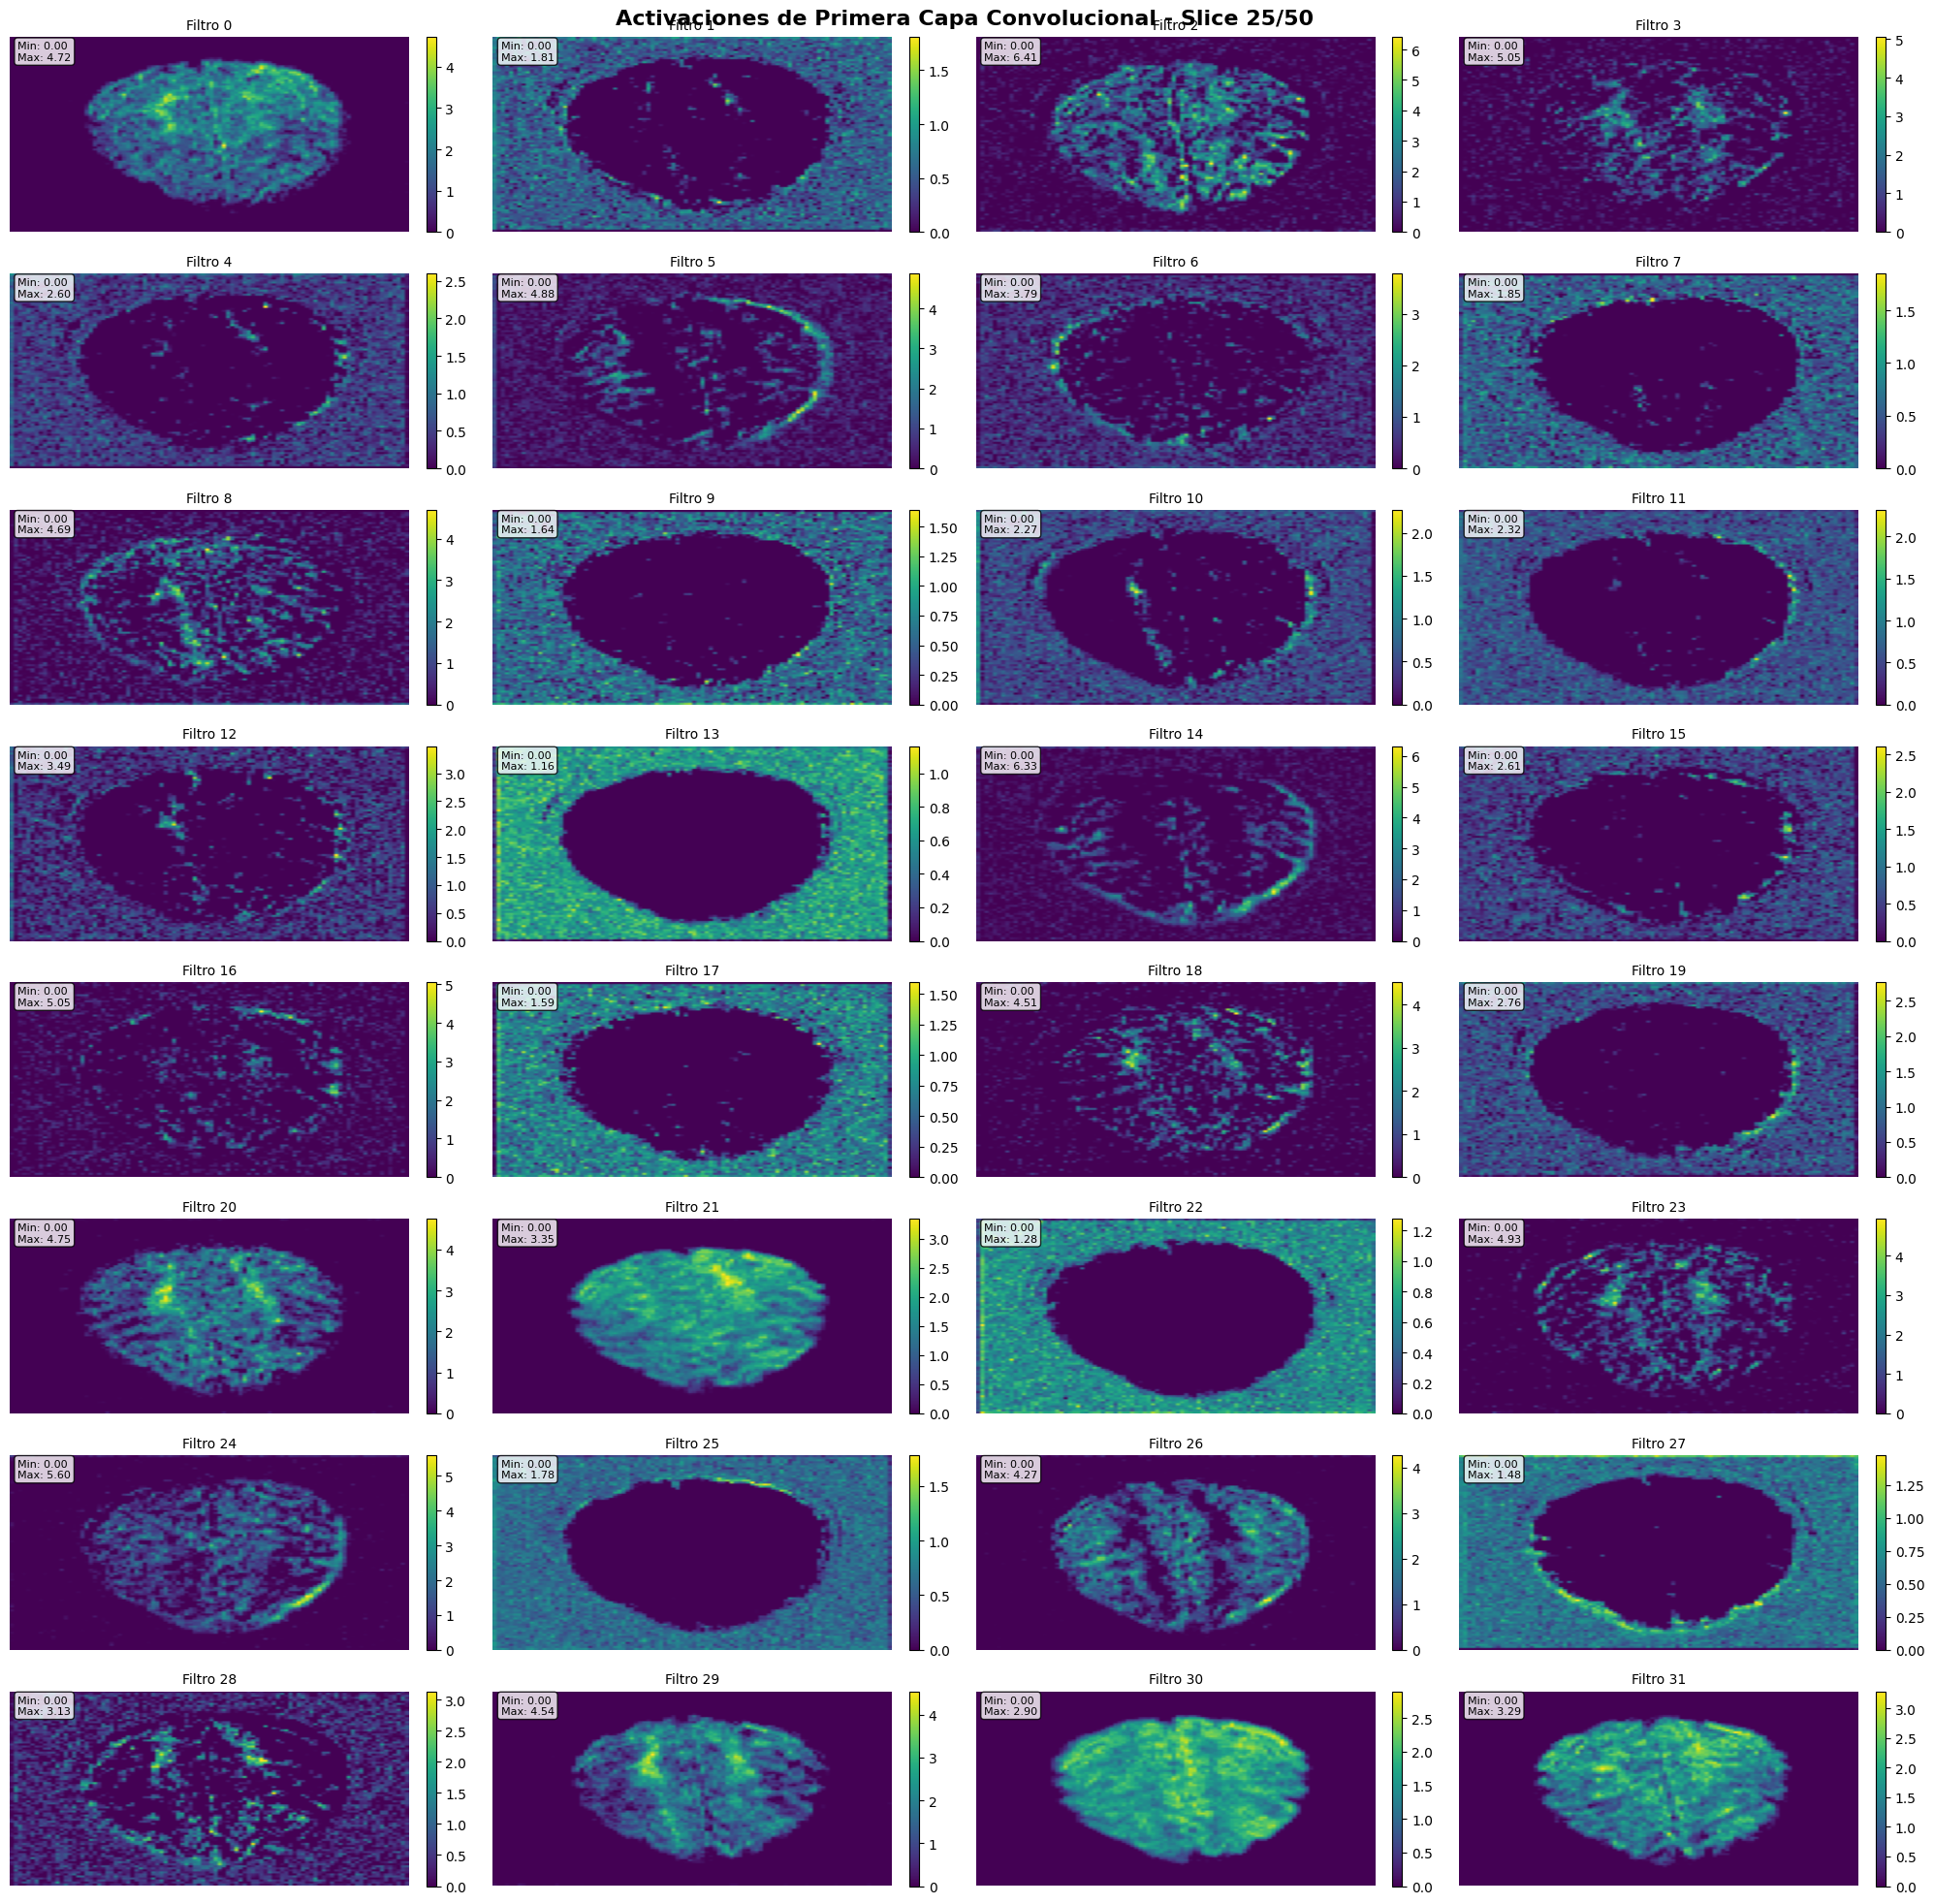

In [ ]:
slice_medio = activaciones.shape[2] // 2  # Slice del medio
visualizar_activaciones_por_slice(activaciones, slice_idx=slice_medio, max_filtros=32,figsize=(20,20))

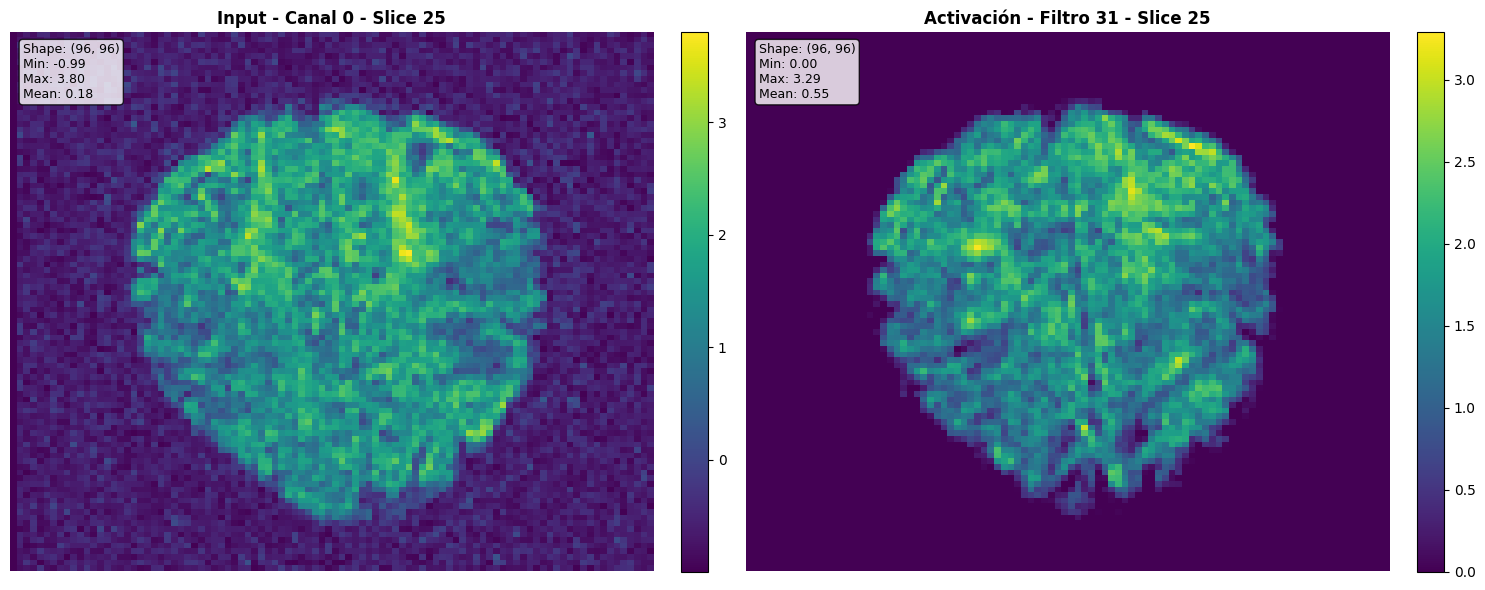

In [ ]:
comparar_input_vs_activaciones(v0, activaciones,
                                   slice_idx=slice_medio,
                                   canal_input=0,
                                   filtro_idx=31)

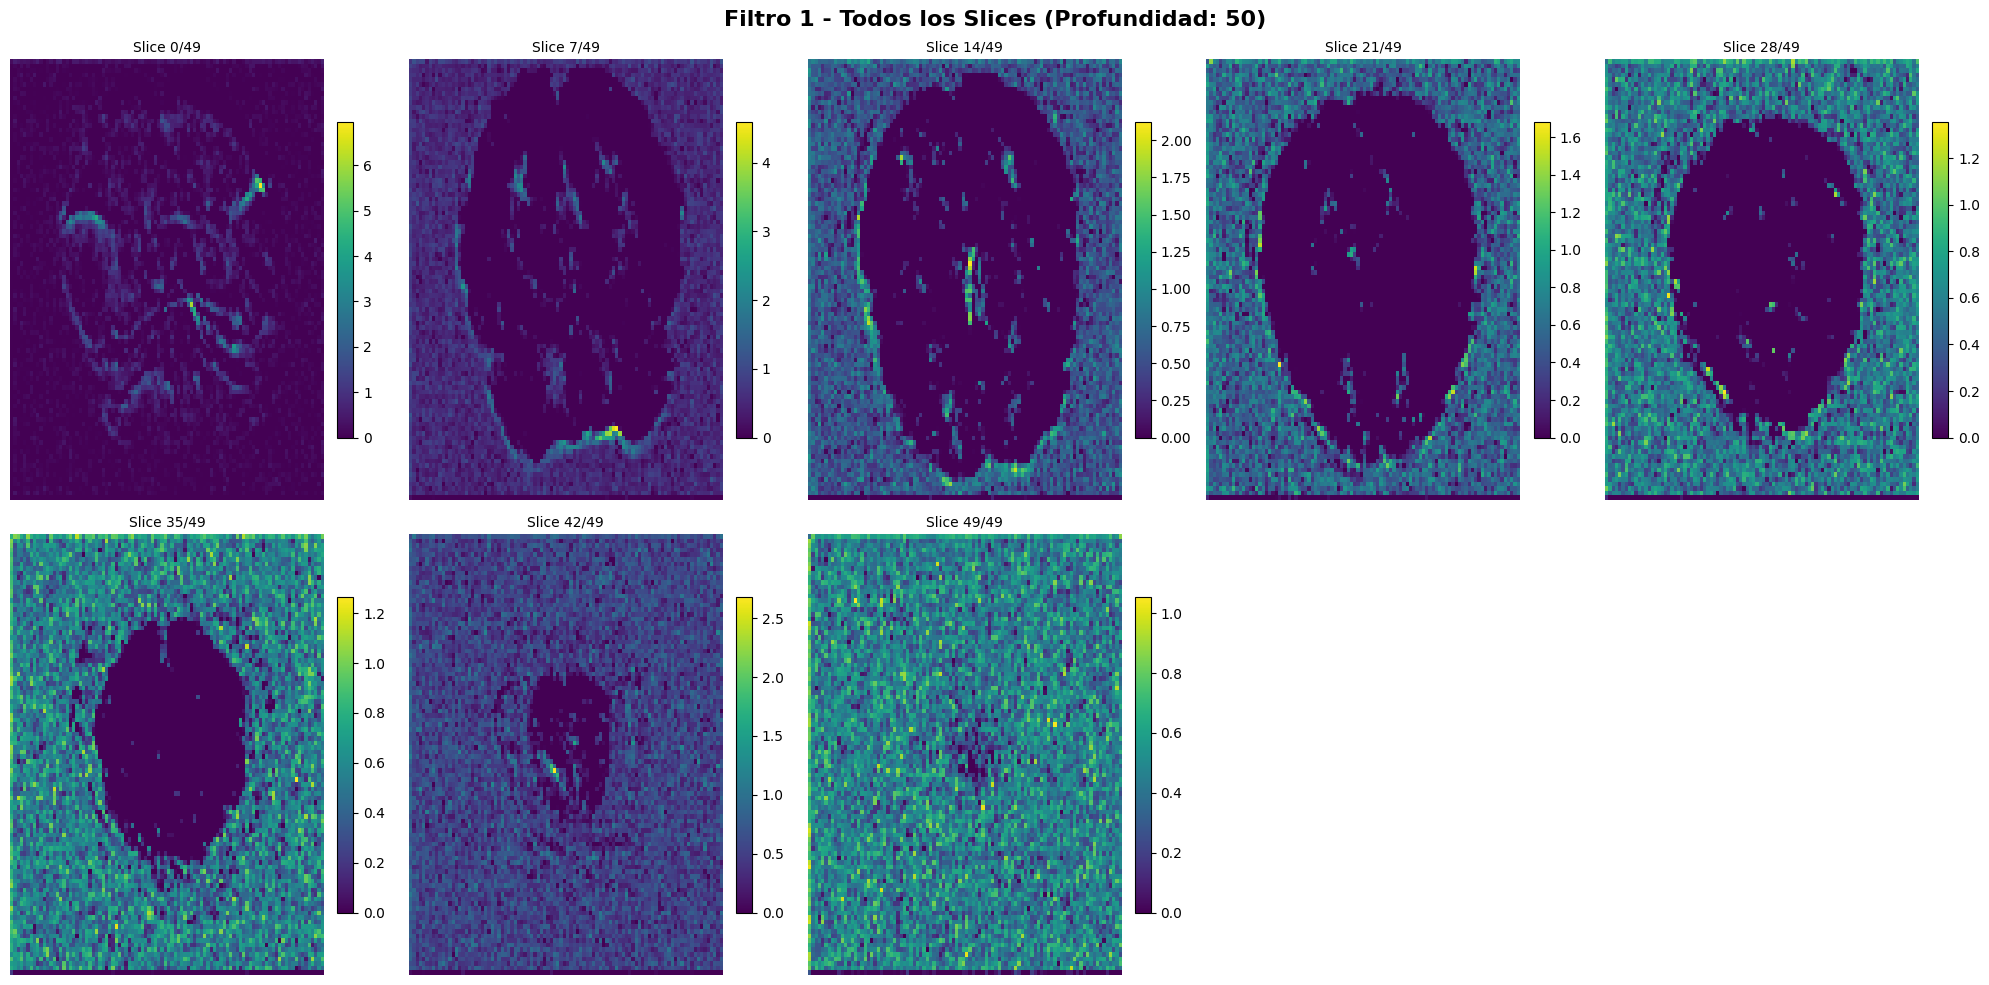

In [ ]:
visualizar_filtro_completo(activaciones, filtro_idx=1, num_slices=8)

In [ ]:
def explorar_interactivo(activaciones, filtro_idx=0):
    """
    Versión interactiva para explorar diferentes slices
    (Requiere widgets de jupyter)
    """
    from ipywidgets import interact, IntSlider

    if activaciones.dim() == 5:
        activaciones = activaciones[0]

    profundidad = activaciones.shape[1]

    @interact(slice_idx=IntSlider(min=0, max=profundidad-1, value=profundidad//2))
    def plot_slice(slice_idx):
        plt.figure(figsize=(10, 8))
        activation_slice = activaciones[filtro_idx, slice_idx, :, :].cpu().numpy()
        plt.imshow(activation_slice, cmap='viridis', aspect='auto')
        plt.colorbar()
        plt.title(f'Filtro {filtro_idx} - Slice {slice_idx}/{profundidad-1}')
        plt.axis('off')
        plt.show()

In [ ]:
explorar_interactivo(activaciones, filtro_idx=5)

interactive(children=(IntSlider(value=25, description='slice_idx', max=49), Output()), _dom_classes=('widget-i…

## Otros modelos probados que fueron malos

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# -------------------------------------------------------
# Bloque Inception 3D (inspirado en la figura)
# -------------------------------------------------------
class Inception3D(nn.Module):
    def __init__(self, in_channels, branch_channels):
        """
        in_channels: canales de entrada
        branch_channels: nº de filtros por rama (int)
        """
        super().__init__()

        # Rama 1: conv 1x1x1
        self.branch1 = nn.Conv3d(in_channels, branch_channels, kernel_size=1, padding=0, bias=False)

        # Rama 2: 1x1x1 -> 3x1x1
        self.branch2_1 = nn.Conv3d(in_channels, branch_channels, kernel_size=1, padding=0, bias=False)
        self.branch2_2 = nn.Conv3d(branch_channels, branch_channels, kernel_size=(3, 1, 1),
                                   padding=(1, 0, 0), bias=False)

        # Rama 3: 1x1x1 -> 1x3x1
        self.branch3_1 = nn.Conv3d(in_channels, branch_channels, kernel_size=1, padding=0, bias=False)
        self.branch3_2 = nn.Conv3d(branch_channels, branch_channels, kernel_size=(1, 3, 1),
                                   padding=(0, 1, 0), bias=False)

        # Rama 4: 1x1x1 -> 1x1x3
        self.branch4_1 = nn.Conv3d(in_channels, branch_channels, kernel_size=1, padding=0, bias=False)
        self.branch4_2 = nn.Conv3d(branch_channels, branch_channels, kernel_size=(1, 1, 3),
                                   padding=(0, 0, 1), bias=False)

        # Rama 5: maxpool 3x3x3 -> 1x1x1
        self.branch5_pool = nn.MaxPool3d(kernel_size=3, stride=1, padding=1)
        self.branch5_conv = nn.Conv3d(in_channels, branch_channels, kernel_size=1, padding=0, bias=False)

        self.bn = nn.BatchNorm3d(branch_channels * 5)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        b1 = self.branch1(x)

        b2 = self.branch2_1(x)
        b2 = self.branch2_2(b2)

        b3 = self.branch3_1(x)
        b3 = self.branch3_2(b3)

        b4 = self.branch4_1(x)
        b4 = self.branch4_2(b4)

        b5 = self.branch5_pool(x)
        b5 = self.branch5_conv(b5)

        # concatenación en canales
        out = torch.cat([b1, b2, b3, b4, b5], dim=1)
        out = self.bn(out)
        out = self.relu(out)
        return out


# -------------------------------------------------------
# Bloque Inception-ResNet (Inception + skip connection)
# -------------------------------------------------------
class InceptionResNetBlock3D(nn.Module):
    def __init__(self, in_channels, branch_channels, scale=1.0):
        """
        in_channels: canales de entrada
        branch_channels: nº de filtros por rama dentro del Inception
        scale: cuánto pesa la rama residual antes de sumarla
        """
        super().__init__()
        self.inception = Inception3D(in_channels, branch_channels)

        # Proyección para igualar dimensiones (si hace falta)
        out_channels = branch_channels * 5
        if out_channels != in_channels:
            self.match_channels = nn.Conv3d(out_channels, in_channels, kernel_size=1, bias=False)
        else:
            self.match_channels = nn.Identity()

        self.scale = scale
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = x
        out = self.inception(x)              # [B, 5*branch_channels, D,H,W]
        out = self.match_channels(out)       # [B, in_channels, D,H,W]
        out = residual + self.scale * out    # conexión residual
        out = self.relu(out)
        return out


# -------------------------------------------------------
# Arquitectura completa Inception-ResNet 3D
# -------------------------------------------------------
class InceptionResNet3D(nn.Module):
    def __init__(self, in_channels=64, num_classes=2, base_channels=32):
        """
        in_channels: nº de canales de entrada (en tu caso 64 DWI)
        num_classes: 2 para binario
        base_channels: nº de filtros base (puedes subir a 48/64 si tienes GPU)
        """
        super().__init__()

        # Bloque inicial
        self.stem = nn.Sequential(
            nn.Conv3d(in_channels, base_channels, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm3d(base_channels),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=3, stride=2, padding=1),
        )
        # Ahora aprox: D=50 -> 13, H/W=96 -> 24 (como referencia)

        # Stage 1: mantiene resolución, aumenta canales
        self.stage1_conv = nn.Conv3d(base_channels, base_channels * 2, kernel_size=3, stride=1, padding=1, bias=False)
        self.stage1_bn = nn.BatchNorm3d(base_channels * 2)
        self.stage1_block1 = InceptionResNetBlock3D(in_channels=base_channels * 2,
                                                    branch_channels=base_channels // 2)
        self.stage1_block2 = InceptionResNetBlock3D(in_channels=base_channels * 2,
                                                    branch_channels=base_channels // 2)

        # Downsample 1
        self.down1 = nn.MaxPool3d(kernel_size=3, stride=2, padding=1)
        # Stage 2
        c2 = base_channels * 4
        self.stage2_conv = nn.Conv3d(base_channels * 2, c2, kernel_size=3, stride=1, padding=1, bias=False)
        self.stage2_bn = nn.BatchNorm3d(c2)
        self.stage2_block1 = InceptionResNetBlock3D(in_channels=c2, branch_channels=base_channels)
        self.stage2_block2 = InceptionResNetBlock3D(in_channels=c2, branch_channels=base_channels)

        # Downsample 2
        self.down2 = nn.MaxPool3d(kernel_size=3, stride=2, padding=1)
        # Stage 3
        c3 = base_channels * 8
        self.stage3_conv = nn.Conv3d(c2, c3, kernel_size=3, stride=1, padding=1, bias=False)
        self.stage3_bn = nn.BatchNorm3d(c3)
        self.stage3_block1 = InceptionResNetBlock3D(in_channels=c3, branch_channels=base_channels * 2)
        self.stage3_block2 = InceptionResNetBlock3D(in_channels=c3, branch_channels=base_channels * 2)

        # Cabeza de clasificación
        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.dropout = nn.Dropout(p=0.5)
        self.fc = nn.Linear(c3, num_classes)

    def forward(self, x):
        # x: [B, C, D, H, W]
        x = self.stem(x)

        x = self.stage1_conv(x)
        x = self.stage1_bn(x)
        x = F.relu(x, inplace=True)
        x = self.stage1_block1(x)
        x = self.stage1_block2(x)

        x = self.down1(x)
        x = self.stage2_conv(x)
        x = self.stage2_bn(x)
        x = F.relu(x, inplace=True)
        x = self.stage2_block1(x)
        x = self.stage2_block2(x)

        x = self.down2(x)
        x = self.stage3_conv(x)
        x = self.stage3_bn(x)
        x = F.relu(x, inplace=True)
        x = self.stage3_block1(x)
        x = self.stage3_block2(x)

        x = self.avgpool(x)          # [B, C3, 1,1,1]
        x = torch.flatten(x, 1)      # [B, C3]
        x = self.dropout(x)
        x = self.fc(x)               # [B, num_classes]
        return x


def inception_resnet3d_dwi():
    """
    Helper para tu caso específico:
    entrada 64 canales DWI, salidas 2 clases (control/paciente)
    """
    return InceptionResNet3D(in_channels=64, num_classes=2, base_channels=32)

In [ ]:
# ==========================
# MODELO: RESNET 3D PEQUEÑA (~14 capas)
# ==========================

class BasicBlock3D(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv3d(
            in_planes, planes,
            kernel_size=3, stride=stride,
            padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm3d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv3d(
            planes, planes,
            kernel_size=3, stride=1,
            padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm3d(planes)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out


class ResNet3D(nn.Module):
    """
    ResNet-14 3D:
        Conv inicial + 4 stages de bloques residuales (1 bloque/stage)
        + AdaptiveAvgPool + Dropout + Linear binario.
    """

    def __init__(self, block, layers, in_channels=64, num_classes=2):
        super().__init__()
        self.in_planes = 64

        # Capa inicial
        self.conv1 = nn.Conv3d(
            in_channels, 64,
            kernel_size=7, stride=2,
            padding=3, bias=False
        )
        self.bn1 = nn.BatchNorm3d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool3d(kernel_size=3, stride=2, padding=1)

        # Stages residuales
        self.layer1 = self._make_layer(block, 64,  layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        # Pooling global + dropout + clasificador binario
        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.dropout = nn.Dropout(p=0.5)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, blocks, stride):
        downsample = None
        if stride != 1 or self.in_planes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv3d(
                    self.in_planes, planes * block.expansion,
                    kernel_size=1, stride=stride, bias=False
                ),
                nn.BatchNorm3d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.in_planes, planes, stride, downsample))
        self.in_planes = planes * block.expansion

        for _ in range(1, blocks):
            layers.append(block(self.in_planes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        # x: (B, C, D, H, W)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)         # (B, 512, 1,1,1)
        x = torch.flatten(x, 1)     # (B, 512)
        x = self.dropout(x)         # anti-overfitting
        x = self.fc(x)              # (B, 2)
        return x


def resnet14_3d(in_channels=64, num_classes=2):
    return ResNet3D(BasicBlock3D, [1, 1, 1, 1],
                    in_channels=in_channels,
                    num_classes=num_classes)